# **ML-модель для декодирования кода Морзе**

### Установка и импорт необходимых  библиотек и зависимостей

In [2]:
# Установка пакетов в окружение Conda
# %conda install -c conda-forge numpy scipy -y
# %conda install -c conda-forge pandas -y
# %conda install -c conda-forge matplotlib seaborn -y
# %conda install -c pytorch pytorch torchvision torchaudio -y
# %conda install -c conda-forge librosa -y
# %conda install -c conda-forge pydub -y
# %conda install -c conda-forge ffmpeg -y
# %conda install -c conda-forge scikit-learn -y
# %conda install -c conda-forge tqdm -y
# %conda install -c conda-forge tensorboard -y
# %conda install -c conda-forge python-Levenshtein -y
# %conda install -c conda-forge opencv -y
# %pip install noisereduce
# %conda install -c conda-forge scikit-image -y

In [1]:
# Импорт библиотек 
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import scipy as scp
import scipy.fft as fourier
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio as ta
from torch.utils.data import random_split, Dataset, DataLoader, Subset
import librosa
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight as ccw
import cv2
import soundfile as sf
from sklearn.model_selection import train_test_split

import Levenshtein

import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.rc("font", size=14)

In [ ]:
# Проверка кодека и установки пакетов
!ffmpeg -version
!conda list

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
built with clang version 16.0.6
configuration: --prefix=/opt/anaconda3/envs/morseML --cc=arm64-apple-darwin20.0.0-clang --cxx=arm64-apple-darwin20.0.0-clang++ --nm=arm64-apple-darwin20.0.0-nm --ar=arm64-apple-darwin20.0.0-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1714861921732/_build_env/bin/x86_64-apple-darwin13.4.0-clang --enable-neon --enable-gnutls --enable-libmp3lame --enable-libvpx --enable-libass --enable-pthreads --enable-libopenvino --enable-gpl --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-pic --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libopus 

### Импорт датасетов

In [2]:
train_dataframe = pd.read_csv("train.csv")
train_dataframe.head()

id     message
0  1.opus  03ЩУЫЛПИГХ
1  2.opus  ЪЛТ0ДС6А3Г
2  3.opus   5ЭКЫБЗХЯН
3  4.opus   ЖЫЦОИ68КФ
4  5.opus   32Ю7МЫ ЗЛ

In [4]:
test_dataframe = pd.read_csv("test.csv")
test_dataframe.head()

id
0  30001.opus
1  30002.opus
2  30003.opus
3  30004.opus
4  30005.opus

### Визуализация аудиоданных

In [5]:
FILES_DIR = "morse_dataset/morse_dataset"

file = '1.opus'
file_path = f"{FILES_DIR}/{file}"
waveform, sample_rate = librosa.load(file_path, sr=None)

print(f"Длина сигнала: {waveform.shape[0]}")
print(f"Частота дискретизации: {sample_rate}")
print(f"Длительность сигнала: {waveform.shape[0] / sample_rate:.2f} с")

Длина сигнала: 64000
Частота дискретизации: 8000
Длительность сигнала: 8.00 с


In [174]:
# Построение амплитудно-временной характеристики сигнала
plt.figure(figsize=(14, 4))

plt.plot(np.linspace(0, waveform.shape[0] / sample_rate, num=waveform.shape[0]), waveform, c="navy", alpha=0.8, lw=0.7)
plt.title("График аудиосигнала")
plt.xlabel("Время, с")
plt.ylabel("Амплитуда")
plt.xlim([0, waveform.shape[0] / sample_rate])
plt.grid()

plt.tight_layout()
plt.show()

NameError: name 'waveform' is not defined

<Figure size 1400x400 with 0 Axes>

#### Пробная предобработка

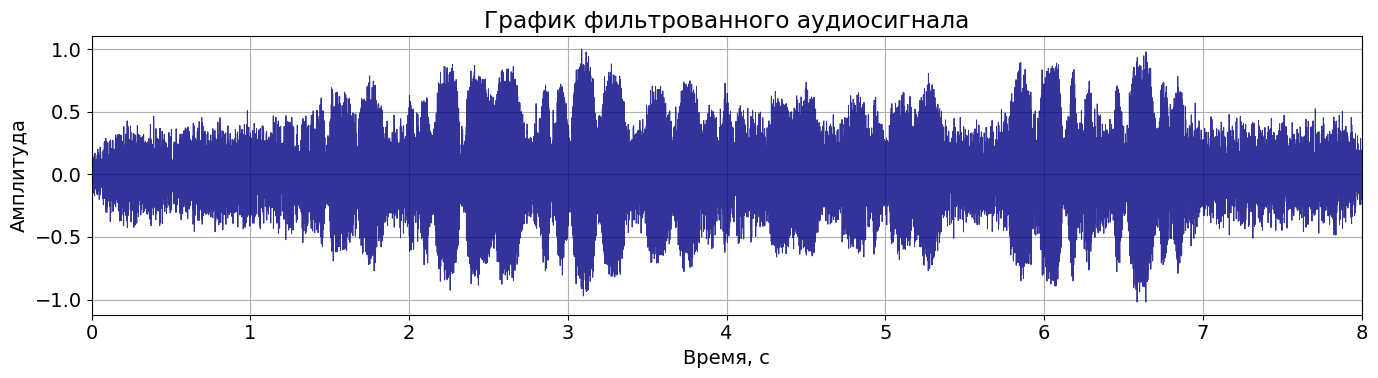

In [441]:
def spectral_noise_reduction(y, n_fft=2048, hop_length=512, noise_frames=15):
    # Получаем спектр
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    magnitude, phase = np.abs(S), np.angle(S)

    # Оцениваем "шум" как среднее первых N фреймов
    noise_profile = np.mean(magnitude[:, :noise_frames], axis=1, keepdims=True)

    # Вычитаем шум
    magnitude_denoised = np.maximum(magnitude - noise_profile, 0)

    # Восстанавливаем сигнал
    S_denoised = magnitude_denoised * np.exp(1j * phase)
    y_denoised = librosa.istft(S_denoised, hop_length=hop_length)
    return y_denoised

y_clean = spectral_noise_reduction(waveform)

plt.figure(figsize=(14, 4))
plt.plot(np.linspace(0, waveform.shape[0] / sample_rate, num=waveform.shape[0]), y_clean, c="navy", alpha=0.8, lw=0.7)
plt.title("График фильтрованного аудиосигнала")
plt.xlabel("Время, с")
plt.ylabel("Амплитуда")
plt.xlim([0, waveform.shape[0] / sample_rate])
plt.grid()

plt.tight_layout()
plt.show()

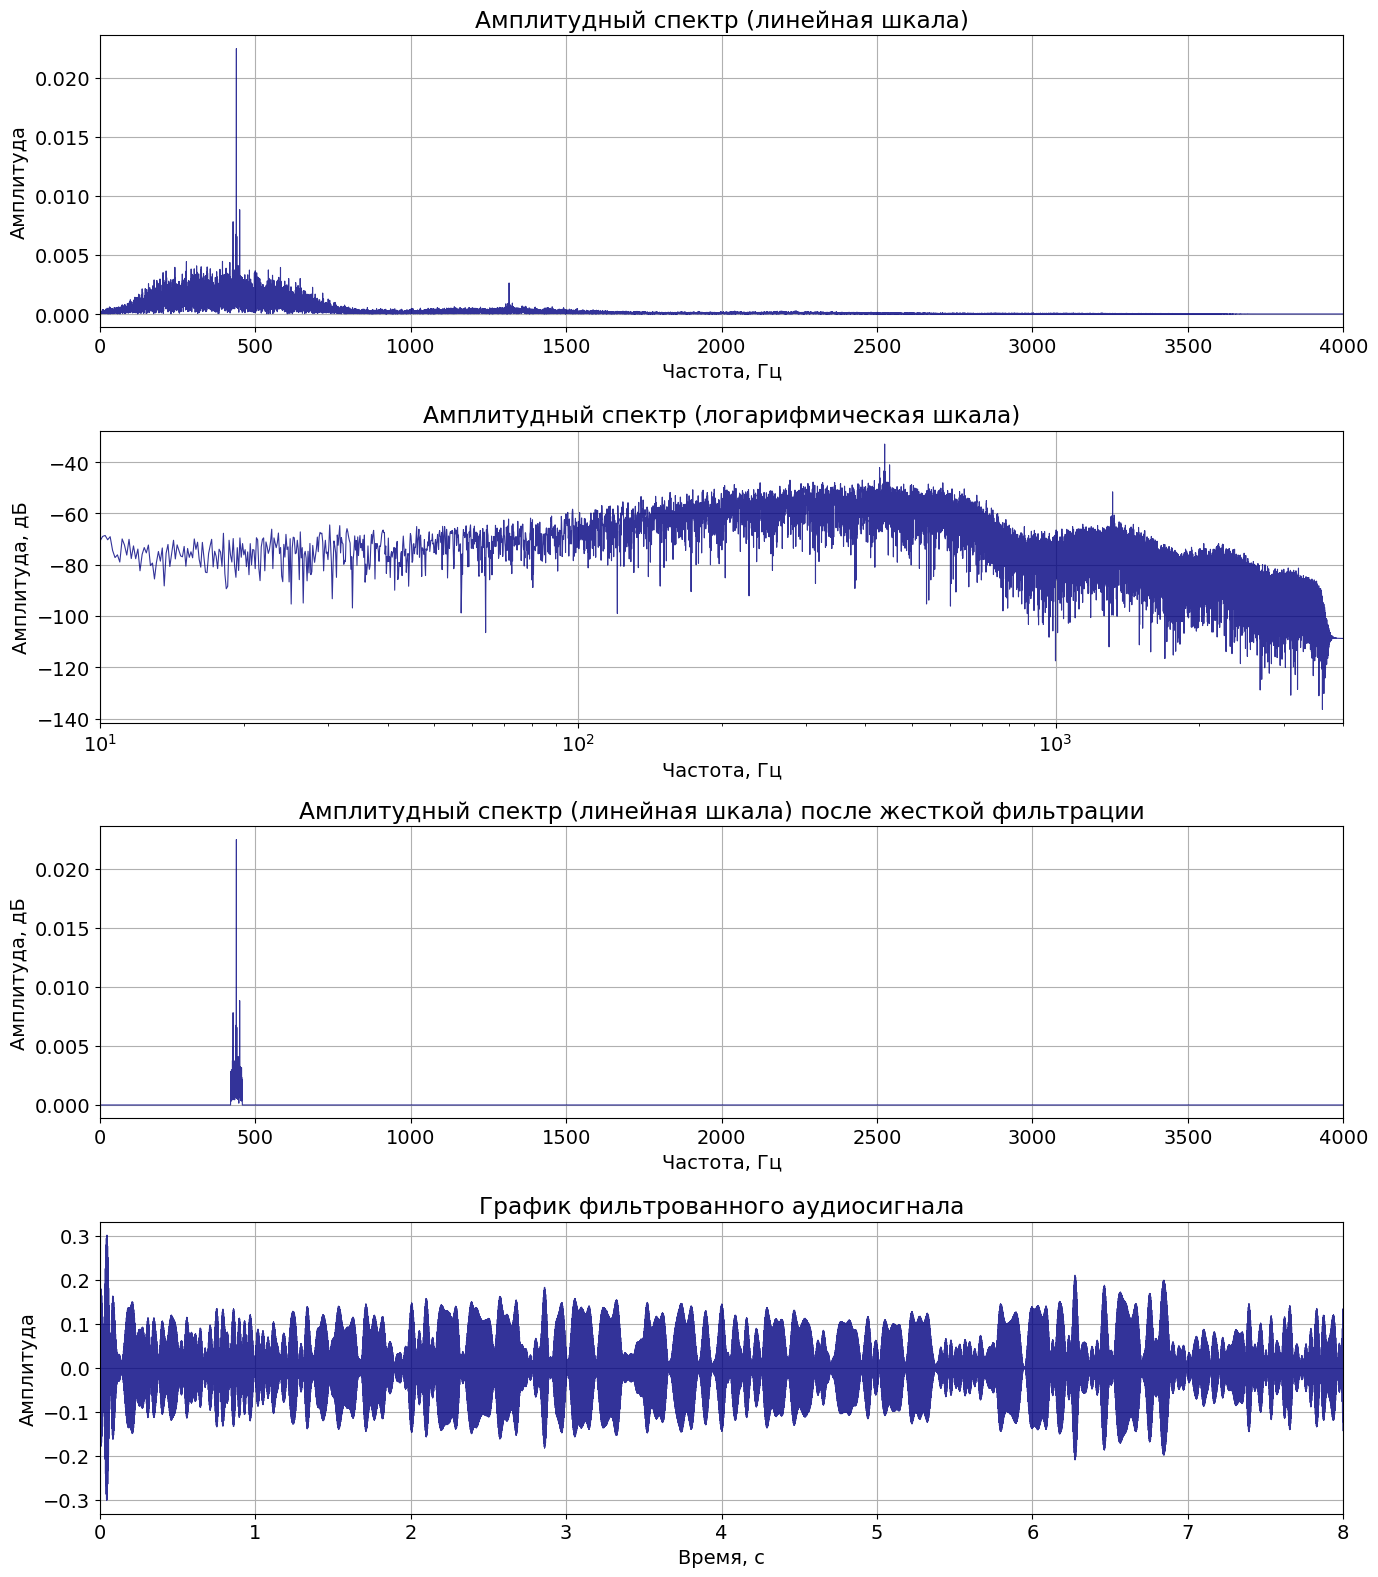

In [451]:
# Амплитудно-частотная характеристика сигнала
waveform = y_processed
signal = waveform / np.max(np.abs(waveform))
N = len(signal)
duration = N / sample_rate

yf = fourier.fft(signal)
xf = fourier.fftfreq(N, 1 / sample_rate)[:N//2]
magnitude = np.abs(yf[:N//2]) / N
magnitude_db = 20 * np.log10(magnitude + 1e-12)

max_amp = np.argmax(magnitude)
cutoff_size = 150
magnitude_filt = [magnitude[i] if (max_amp - cutoff_size) < i < (max_amp + cutoff_size) 
                  else 0 for i in range(len(magnitude))]

yf_filt = np.zeros_like(yf, dtype=complex)

# Левая половина (положительные частоты)
for i in range(len(magnitude_filt)):
    yf_filt[i] = yf[i] if magnitude_filt[i] != 0 else 0

# Правая половина (отрицательные частоты — зеркальное отражение)
# Восстановим симметрию вручную
for i in range(1, len(magnitude_filt)):  # начинаем с 1, чтобы не задвоить DC
    yf_filt[-i] = np.conj(yf_filt[i])

# 2. Обратное преобразование Фурье
filtered_signal = np.real(fourier.ifft(yf_filt))

plt.figure(figsize=(14, 16))

plt.subplot(4, 1, 1)
plt.plot(xf, magnitude, c="navy", alpha=0.8, lw=0.8)
plt.title("Амплитудный спектр (линейная шкала)")
plt.xlabel("Частота, Гц")
plt.ylabel("Амплитуда")
plt.xlim([0, 4000])
plt.grid()

plt.subplot(4, 1, 2)
plt.semilogx(xf, magnitude_db, c="navy", alpha=0.8, lw=0.8)
plt.title("Амплитудный спектр (логарифмическая шкала)")
plt.xlabel("Частота, Гц")
plt.ylabel("Амплитуда, дБ")
plt.xlim(10, sample_rate / 2)
plt.grid()

plt.subplot(4, 1, 3)
plt.plot(xf, magnitude_filt, c="navy", alpha=0.8, lw=0.8)
plt.title("Амплитудный спектр (линейная шкала) после жесткой фильтрации")
plt.xlabel("Частота, Гц")
plt.ylabel("Амплитуда, дБ")
plt.xlim([0, 4000])
plt.grid()

plt.subplot(4, 1, 4)
plt.plot(np.linspace(0, waveform.shape[0] / sample_rate, num=waveform.shape[0]), filtered_signal, c="navy", alpha=0.8, lw=0.7)
plt.title("График фильтрованного аудиосигнала")
plt.xlabel("Время, с")
plt.ylabel("Амплитуда")
plt.xlim([0, waveform.shape[0] / sample_rate])
plt.grid()

plt.tight_layout()
plt.show()

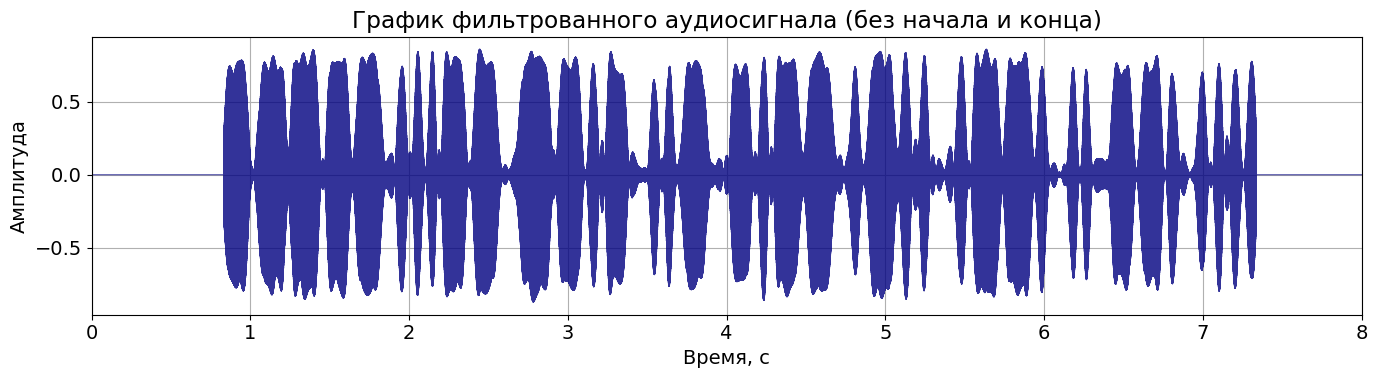

In [355]:
th = 0.3
l, r = 0, len(filtered_signal) - 1
while l < len(filtered_signal):
    if filtered_signal[l] < th:
        filtered_signal[l] = 0
        start = l
    else:
        break
    l += 1

while r > 0:
    if filtered_signal[r] < th:
        filtered_signal[r] = 0
        end = r
    else:
        break
    r -= 1

plt.figure(figsize=(14, 4))
plt.plot(np.linspace(0, waveform.shape[0] / sample_rate, num=waveform.shape[0]), filtered_signal, c="navy", alpha=0.8, lw=0.7)
plt.title("График фильтрованного аудиосигнала (без начала и конца)")
plt.xlabel("Время, с")
plt.ylabel("Амплитуда")
plt.xlim([0, waveform.shape[0] / sample_rate])
plt.grid()

plt.tight_layout()
plt.show()

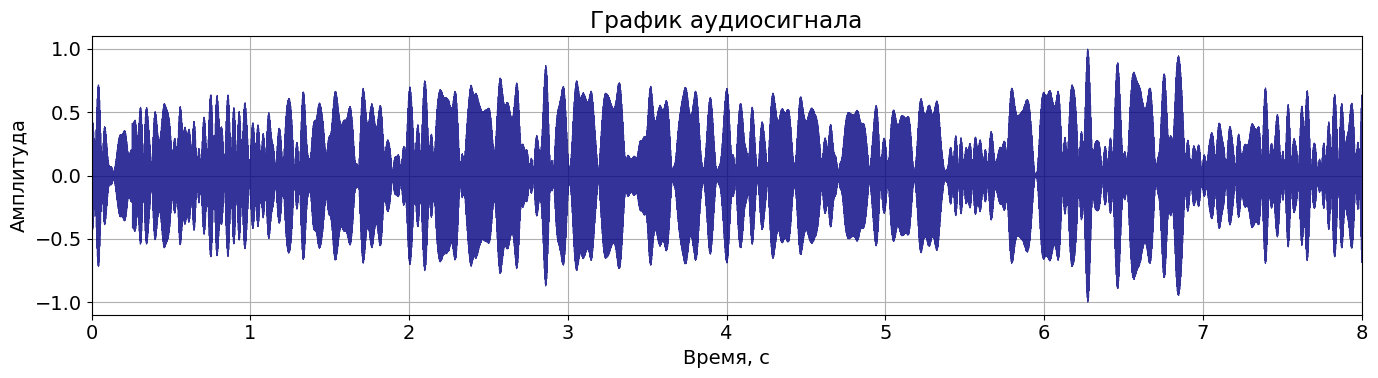

In [452]:
def normalize_rms(filtered_signal, frame_length, hop_length, target_rms):
    rms = librosa.feature.rms(y=filtered_signal, frame_length=frame_length, hop_length=hop_length)[0]
    rms += 1e-12  # во избежание деления на ноль
    gain = target_rms / rms
    gain = np.clip(gain, 2.2, 3.5)  # ограничим усиление, чтобы избежать искажений

    # применим gain покадрово
    y_out = np.zeros_like(filtered_signal)
    for i in range(len(rms)):
        start = i * hop_length
        end = start + frame_length
        y_out[start:end] += filtered_signal[start:end] * gain[i]

    y_out = 2 * (y_out - y_out.min()) / (y_out.max() - y_out.min()) - 1
    return y_out

y_normalized = normalize_rms(filtered_signal, frame_length=4096, hop_length=2048, target_rms=0.7)

# Построение амплитудно-временной характеристики сигнала
plt.figure(figsize=(14, 4))

plt.plot(np.linspace(0, waveform.shape[0] / sample_rate, num=waveform.shape[0]), y_normalized, c="navy", alpha=0.8, lw=0.7)
plt.title("График аудиосигнала")
plt.xlabel("Время, с")
plt.ylabel("Амплитуда")
plt.xlim([0, waveform.shape[0] / sample_rate])
plt.grid()

plt.tight_layout()
plt.show()

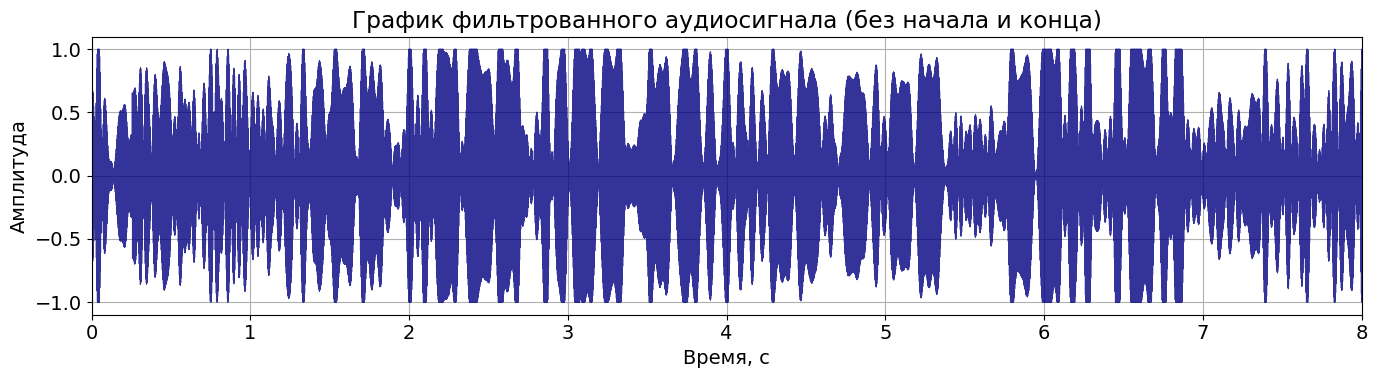

In [453]:
# Нормализация громкости (до -20 дБFS, например)
signal_tensor = torch.tensor(y_normalized, dtype=torch.float32)
normalize = ta.transforms.Vol(gain=4.0, gain_type='db')
normalized_waveform = normalize(signal_tensor)

plt.figure(figsize=(14, 4))
plt.plot(np.linspace(0, waveform.shape[0] / sample_rate, num=waveform.shape[0]), normalized_waveform, c="navy", alpha=0.8, lw=0.7)
plt.title("График фильтрованного аудиосигнала (без начала и конца)")
plt.xlabel("Время, с")
plt.ylabel("Амплитуда")
plt.xlim([0, waveform.shape[0] / sample_rate])
plt.grid()

plt.tight_layout()
plt.show()

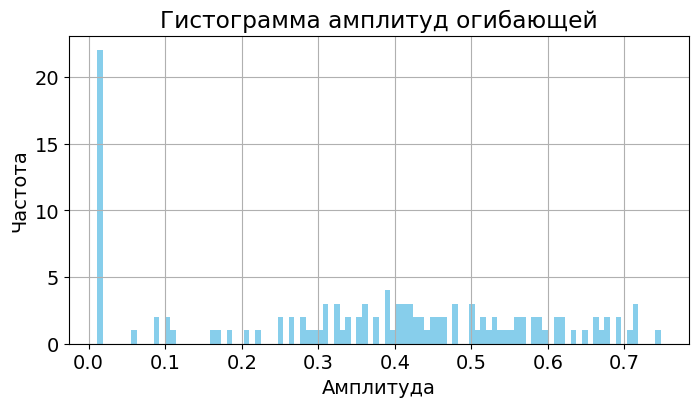

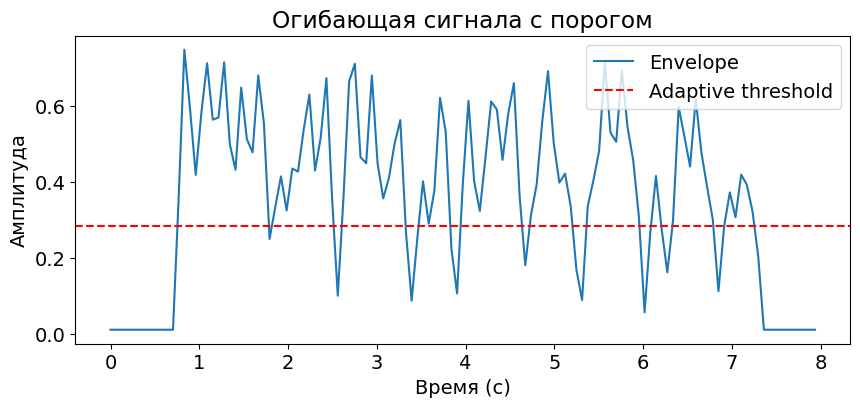

In [361]:
def get_envelope(signal, sr, frame_size=1024, hop_length=512):
    envelope = np.array([
        np.mean(np.abs(signal[i:i+frame_size]))
        for i in range(0, len(signal), hop_length)
    ])
    times = np.arange(len(envelope)) * hop_length / sr
    return envelope, times

def plot_envelope_histogram(envelope):
    plt.figure(figsize=(8, 4))
    plt.hist(envelope, bins=100, color='skyblue')
    plt.title("Гистограмма амплитуд огибающей")
    plt.xlabel("Амплитуда")
    plt.ylabel("Частота")
    plt.grid(True)
    plt.show()

def adaptive_threshold(envelope):
    median = np.median(envelope)
    mad = np.median(np.abs(envelope - median))
    threshold = median + 2 * mad  # коэффициент можно подбирать
    return threshold

from skimage.filters import threshold_otsu

def otsu_threshold(envelope):
    return threshold_otsu(envelope)

envelope, times = get_envelope(np.array(normalized_waveform), 8000)

# Строим гистограмму
plot_envelope_histogram(envelope)

# Порог
# thr = adaptive_threshold(envelope)
thr = otsu_threshold(envelope)

# Визуализируем
plt.figure(figsize=(10, 4))
plt.plot(times, envelope, label='Envelope')
plt.axhline(thr, color='red', linestyle='--', label='Adaptive threshold')
plt.title("Огибающая сигнала с порогом")
plt.xlabel("Время (с)")
plt.ylabel("Амплитуда")
plt.legend()
plt.show()

In [362]:
def get_active_segments(envelope, threshold, hop_length, sr):
    active = envelope > threshold
    changes = np.diff(active.astype(int))
    start_idxs = np.where(changes == 1)[0]
    end_idxs = np.where(changes == -1)[0]

    if end_idxs[0] < start_idxs[0]:
        end_idxs = end_idxs[1:]
    if len(start_idxs) > len(end_idxs):
        start_idxs = start_idxs[:-1]

    starts = start_idxs * hop_length / sr
    ends = end_idxs * hop_length / sr

    return list(zip(starts, ends))

def get_pause_durations(segments):
    pauses = []
    for i in range(1, len(segments)):
        pause = segments[i][0] - segments[i-1][1]
        if pause > 0:
            pauses.append(pause)
    return np.array(pauses)

def classify_pauses(pauses):
    # кластеризация или порог по квантилям
    short_thr = np.percentile(pauses, 33)
    long_thr = np.percentile(pauses, 66)
    return short_thr, long_thr

# from sklearn.cluster import KMeans

# def cluster_time_thresholds(pause_durations, n_clusters=3):
#     X = pause_durations.reshape(-1, 1)
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
#     centers = sorted(kmeans.cluster_centers_.flatten())
#     return centers  # например, [короткая, средняя, длинная]

from skimage.filters import threshold_otsu

def otsu_time_threshold(pause_durations):
    pause_durations = pause_durations[pause_durations > 0]  # убрать нули
    if len(pause_durations) < 2:
        return None
    return threshold_otsu(pause_durations)

segments = get_active_segments(envelope, thr, hop_length=256, sr=8000)
pauses = get_pause_durations(segments)

cutoff = otsu_time_threshold(pauses)

# sh, long = classify_pauses(pauses)

# print(f"Short pause: {short_thr:.3f} s (точка/тире), "
#       f"Middle: {mid_thr:.3f} s (межбуквенная), "
#       f"Long: {long_thr:.3f} s (межсловная)")

print(f"Cutoff: {cutoff}")
# print(sh, long)

Cutoff: 0.03212500000000003


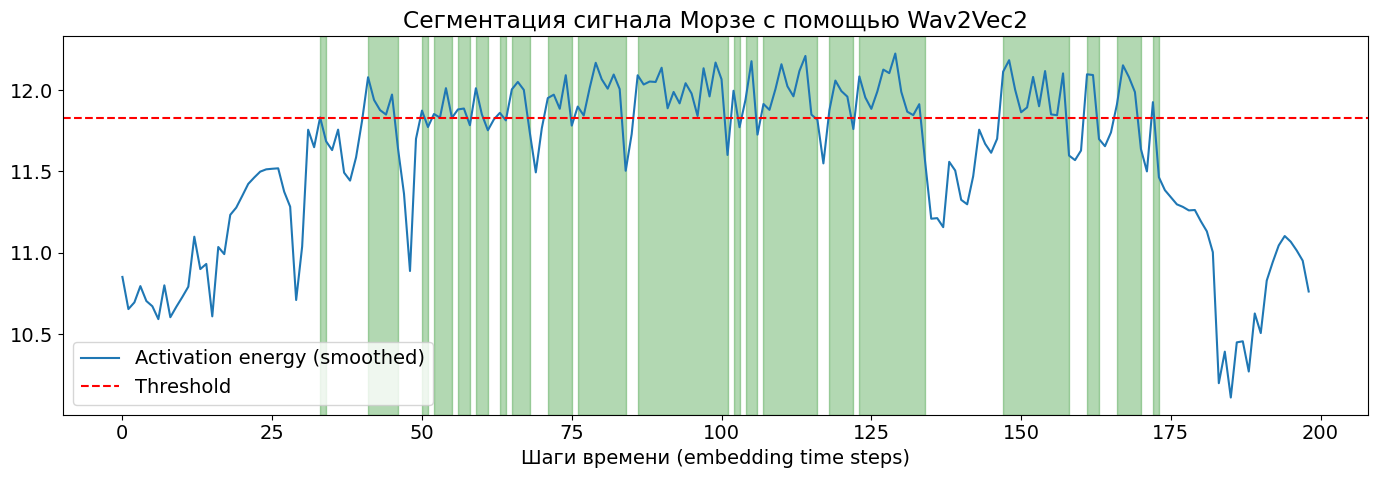

Найденные активные фрагменты (время в секундах):
Сегмент 1: 1.33с – 1.37с
Сегмент 2: 1.65с – 1.85с
Сегмент 3: 2.01с – 2.05с
Сегмент 4: 2.09с – 2.21с
Сегмент 5: 2.25с – 2.33с
Сегмент 6: 2.37с – 2.45с
Сегмент 7: 2.53с – 2.57с
Сегмент 8: 2.61с – 2.73с
Сегмент 9: 2.85с – 3.02с
Сегмент 10: 3.06с – 3.38с
Сегмент 11: 3.46с – 4.06с
Сегмент 12: 4.10с – 4.14с
Сегмент 13: 4.18с – 4.26с
Сегмент 14: 4.30с – 4.66с
Сегмент 15: 4.74с – 4.90с
Сегмент 16: 4.94с – 5.39с
Сегмент 17: 5.91с – 6.35с
Сегмент 18: 6.47с – 6.55с
Сегмент 19: 6.67с – 6.83с
Сегмент 20: 6.91с – 6.95с


In [551]:
# Загрузка модели Wav2Vec2
bundle = ta.pipelines.WAV2VEC2_BASE
model = bundle.get_model()
model.eval()

wf_tensor = torch.tensor(y_normalized)

# Преобразование в моно и ресемплинг до 16кГц (если нужно)
if wf_tensor.ndim == 2 and wf_tensor.shape[0] > 1:
    wf_tensor = wf_tensor.mean(dim=0)

# Приведение к нужному типу и размерности
wf_tensor = wf_tensor.to(torch.float32)
wf_tensor = wf_tensor.unsqueeze(0)  # [1, time]

# # Ресемплинг до 16 кГц
# if sample_rate != bundle.sample_rate:
#     resampler = ta.transforms.Resample(orig_freq=sample_rate, new_freq=bundle.sample_rate)
#     wf_tensor = resampler(wf_tensor)
#     sample_rate = bundle.sample_rate

# Получение эмбеддингов
with torch.inference_mode():
    features, _ = model.extract_features(wf_tensor)

# Берем последний уровень признаков (можно поэкспериментировать)

# embedding = features[3][0]  # [time, feature_dim]

# embedding = torch.stack(features).mean(dim=0)[0]

# weights = torch.tensor([0.1] * 6 + [0.9] * 6)  # например, больше веса верхним слоям
# weights = weights / weights.sum()
# stacked = torch.stack(features)[:, 0]  # [layers, time, dim]
# embedding = torch.einsum('ltd,l->td', stacked, weights)

embedding = torch.cat([features[i][0] for i in [1, 3]], dim=1)  # [time, dim * n_layers]

# Вычисляем норму каждого вектора (энергию признака)
energy = torch.norm(embedding, dim=1).numpy()

# Сглаживаем для лучшей визуализации
energy_smooth = scp.ndimage.gaussian_filter1d(energy, sigma=0.4)

# Пороговое определение активных зон
threshold = np.percentile(energy_smooth, 55)  # можно поэкспериментировать
active_regions = energy_smooth > threshold

# Определение начала и конца каждого активного сегмента
segments = []
current_start = None
for i, active in enumerate(active_regions):
    if active and current_start is None:
        current_start = i
    elif not active and current_start is not None:
        segments.append((current_start, i))
        current_start = None
# Добавляем последний сегмент, если он не завершён
if current_start is not None:
    segments.append((current_start, len(active_regions)))

# Перевод сегментов в секунды
time_per_step = len(wf_tensor[0]) / embedding.shape[0] / sample_rate
segments_sec = [(start * time_per_step, end * time_per_step) for start, end in segments]

# Визуализация
plt.figure(figsize=(14, 5))
plt.plot(energy_smooth, label="Activation energy (smoothed)")
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')

for start, end in segments:
    plt.axvspan(start, end, color='green', alpha=0.3)

plt.title("Сегментация сигнала Морзе с помощью Wav2Vec2")
plt.xlabel("Шаги времени (embedding time steps)")
plt.legend()
plt.tight_layout()
plt.show()

# Печать сегментов в секундах
print("Найденные активные фрагменты (время в секундах):")
for i, (start, end) in enumerate(segments_sec):
    print(f"Сегмент {i+1}: {start:.2f}с – {end:.2f}с")

In [552]:
def normalize_rms(filtered_signal, frame_length, hop_length, target_rms):
    rms = librosa.feature.rms(y=filtered_signal, frame_length=frame_length, hop_length=hop_length)[0]
    rms += 1e-12  # во избежание деления на ноль
    gain = target_rms / rms
    gain = np.clip(gain, 2.2, 3.5)  # ограничим усиление, чтобы избежать искажений

    # применим gain покадрово
    y_out = np.zeros_like(waveform)
    for i in range(len(rms)):
        start = i * hop_length
        end = start + frame_length
        print(filtered_signal[start:end].shape, gain[i].shape, rms.shape, y_out[start:end].shape)
        y_out[start:end] += filtered_signal[start:end] * gain[i]

    y_out = 2 * (y_out - y_out.min()) / (y_out.max() - y_out.min()) - 1
    return y_out

y_normalized = normalize_rms(filtered_signal, frame_length=4096, hop_length=1024, target_rms=0.95)

(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)
(4096,) () (63,) (4096,)


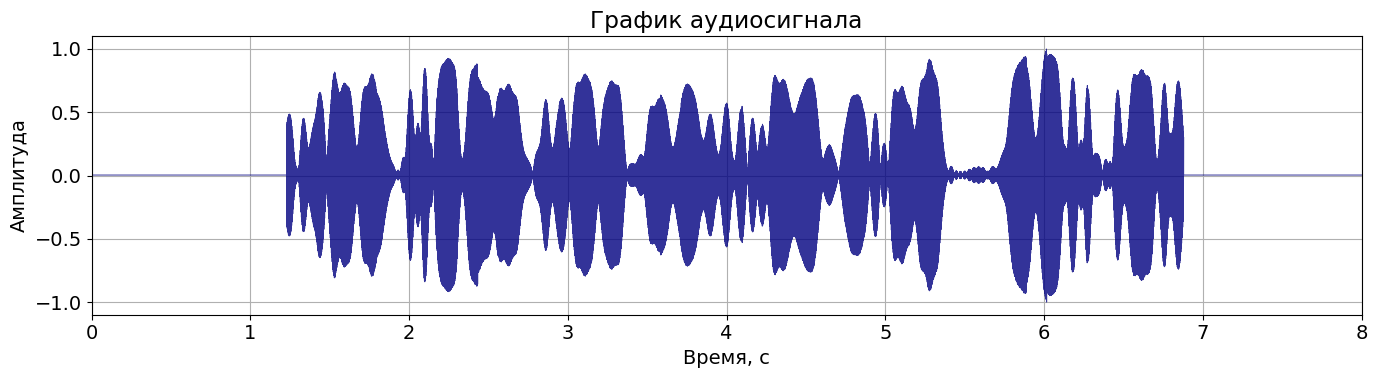

In [553]:
# Построение амплитудно-временной характеристики сигнала
plt.figure(figsize=(14, 4))

plt.plot(np.linspace(0, waveform.shape[0] / sample_rate, num=waveform.shape[0]), y_normalized, c="navy", alpha=0.8, lw=0.7)
plt.title("График аудиосигнала")
plt.xlabel("Время, с")
plt.ylabel("Амплитуда")
plt.xlim([0, waveform.shape[0] / sample_rate])
plt.grid()

plt.tight_layout()
plt.show()

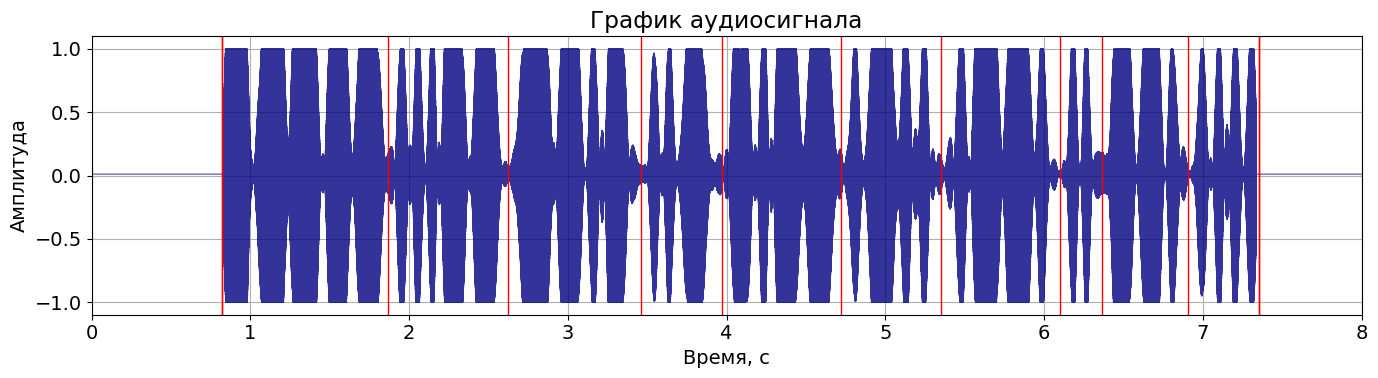

In [363]:
ampl_threshold = thr
time_threshold = 500
blank_threshold = 2500

curr_pause = 0

separations = []
flag = []

l = start + 1
while l <= end - 1:
    if normalized_waveform[l] < ampl_threshold:
        flag.append(l)
        curr_pause += 1
        if normalized_waveform[l + 1] > ampl_threshold:
            if curr_pause >= time_threshold:
                separations.append(l - 400)
                if curr_pause >= blank_threshold:
                    separations.append(flag[0] + 100)

            curr_pause = 0
            flag = []
    l += 1

separations = sorted([start - 100] + separations + [end + 100])

for i in range(len(separations) - 1):
    if separations[i + 1] - separations[i] > 4 * blank_threshold:
        separations.append((separations[i + 1] + separations[i]) // 2)

separations = sorted(separations)

plt.figure(figsize=(14, 4))

time = np.linspace(0, waveform.shape[0] / sample_rate, num=waveform.shape[0])

plt.plot(time, normalized_waveform, c="navy", alpha=0.8, lw=0.7)
for s in separations+[start - 100, end + 100]:
    plt.axvline(x=time[s], color='r', linewidth=1)
plt.title("График аудиосигнала")
plt.xlabel("Время, с")
plt.ylabel("Амплитуда")
plt.xlim([0, waveform.shape[0] / sample_rate])
plt.grid()

plt.tight_layout()
plt.show()

In [566]:
separations

[]

In [547]:
letters_train = pd.DataFrame({
    'id': [],
    'letter': []
})

In [548]:
if (len(separations) - 1) == len(train_data.loc[train_data['id'] == file, 'message'].values[0]):
    for p in range(len(separations) - 1):
        sf.write(f'morse_dataset/letters_dataset/{file[:-5]}_{p + 1}.wav', 
                 normalized_waveform[separations[p]:separations[p + 1]], samplerate=sample_rate)
        letters_train.loc[len(letters_train)] = [f'{file[:-5]}_{p + 1}.wav', (train_data.loc[train_data['id'] == file, 'message'].values[0])[p]]

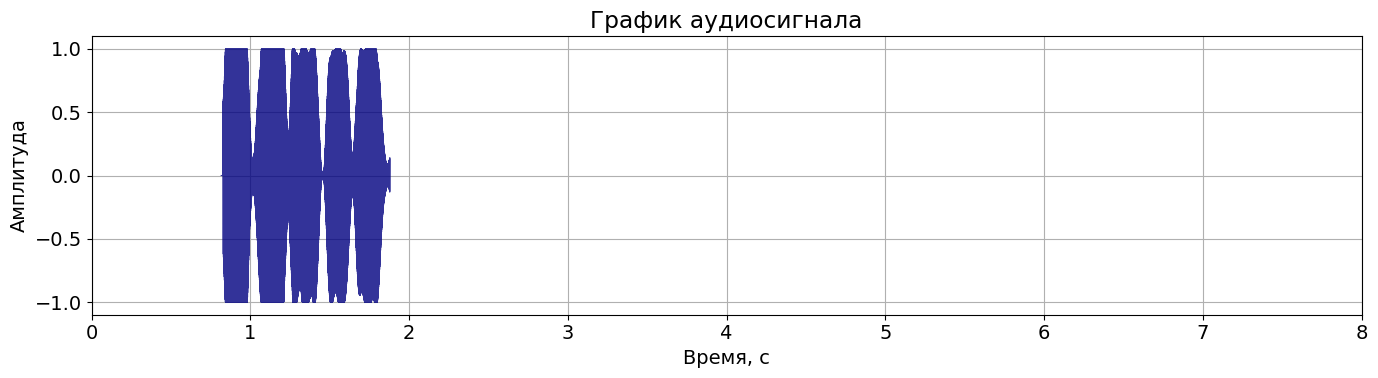

In [52]:
plt.figure(figsize=(14, 4))

time = np.linspace(0, waveform.shape[0] / sample_rate, num=waveform.shape[0])

plt.plot(time[separations[0]:separations[1]], normalized_waveform[separations[0]:separations[1]], c="navy", alpha=0.8, lw=0.7)
plt.title("График аудиосигнала")
plt.xlabel("Время, с")
plt.ylabel("Амплитуда")
plt.xlim([0, waveform.shape[0] / sample_rate])
plt.grid()

plt.tight_layout()
plt.show()

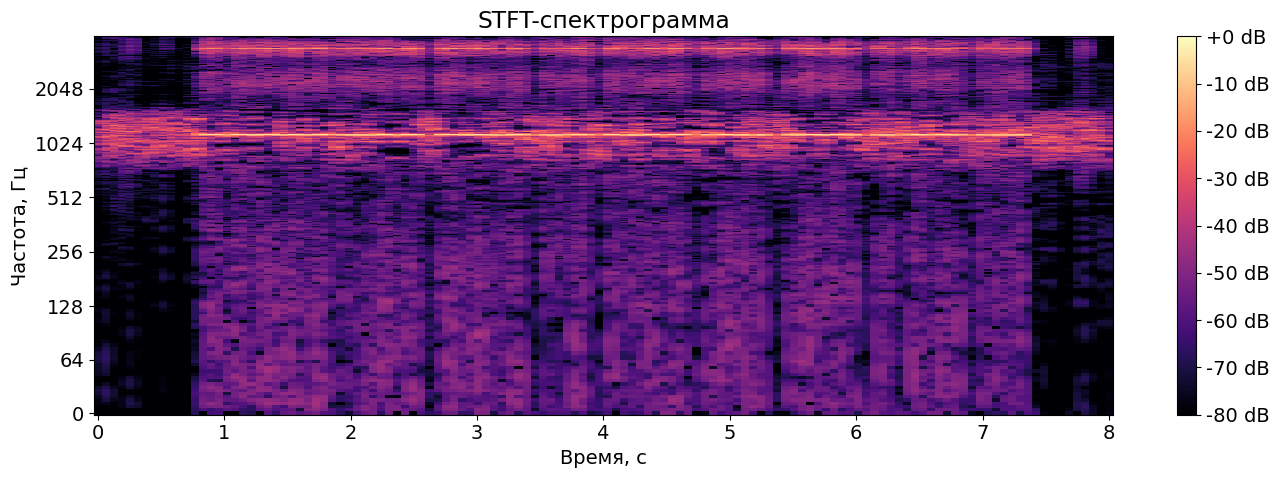

In [ ]:
# Построение спектрограммы сигнала
plt.figure(figsize=(14, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(waveform)), ref=np.max)
librosa.display.specshow(D, y_axis='log', x_axis='time', sr=sample_rate)

plt.colorbar(format="%+2.0f dB")
plt.xlabel('Время, с')
plt.ylabel('Частота, Гц')
plt.title('STFT-спектрограмма')
plt.tight_layout()
plt.show()

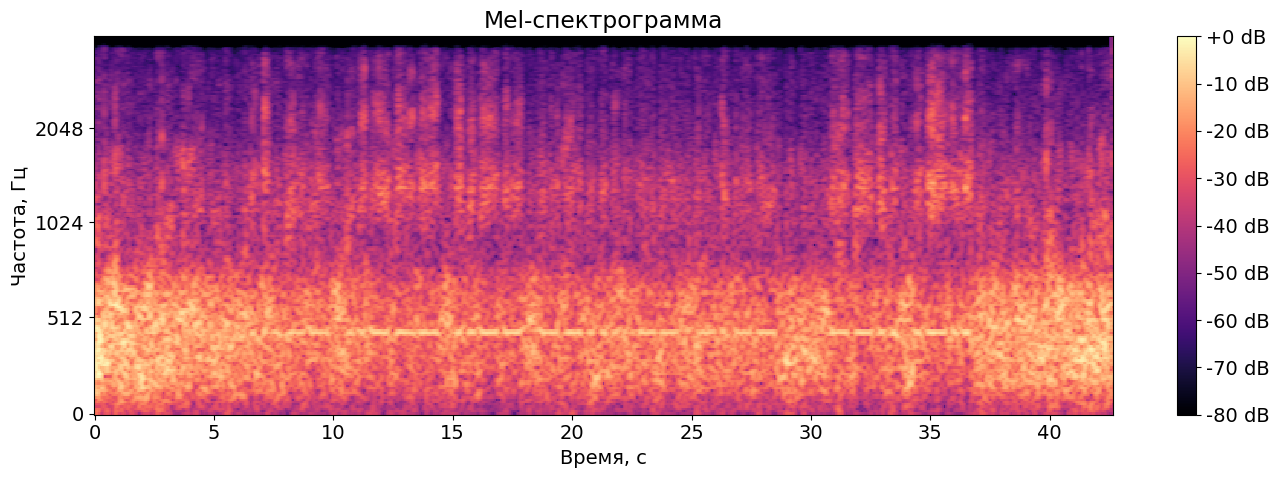

In [454]:
# Построение Mel-спектрограммы сигнала (лучше в ML-задачах распознавания речи)
plt.figure(figsize=(14, 5))
S = librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=192, n_fft=768, hop_length=96)
S_dB = librosa.power_to_db(S, ref=np.max)
# S_dB = (S_dB - S_dB.min()) / (S_dB.max() - S_dB.min())  # Нормализация
librosa.display.specshow(S_dB, sr=sample_rate, x_axis="time", y_axis="mel")

plt.colorbar(format="%+2.0f dB")
plt.title("Mel-спектрограмма")
plt.xlabel("Время, с")
plt.ylabel("Частота, Гц")
plt.tight_layout()
plt.show()

In [48]:
S_dB.shape

(192, 667)

In [455]:
n_mels = S_dB.shape[0]
fmin = 0
fmax = 4000

# 1. Сумма по времени (ось 1)
mel_sums = np.sum(S_dB, axis=1)

# 2. Индекс максимальной суммы
max_idx = np.argmax(mel_sums)

# 3. Получить реальные частоты каждой мел-линии
mel_frequencies = librosa.mel_frequencies(n_mels=n_mels, fmin=fmin, fmax=fmax)

# 4. Частота, на которой максимум
dominant_freq = mel_frequencies[max_idx]
dominant_freq

np.float64(429.57473333737613)

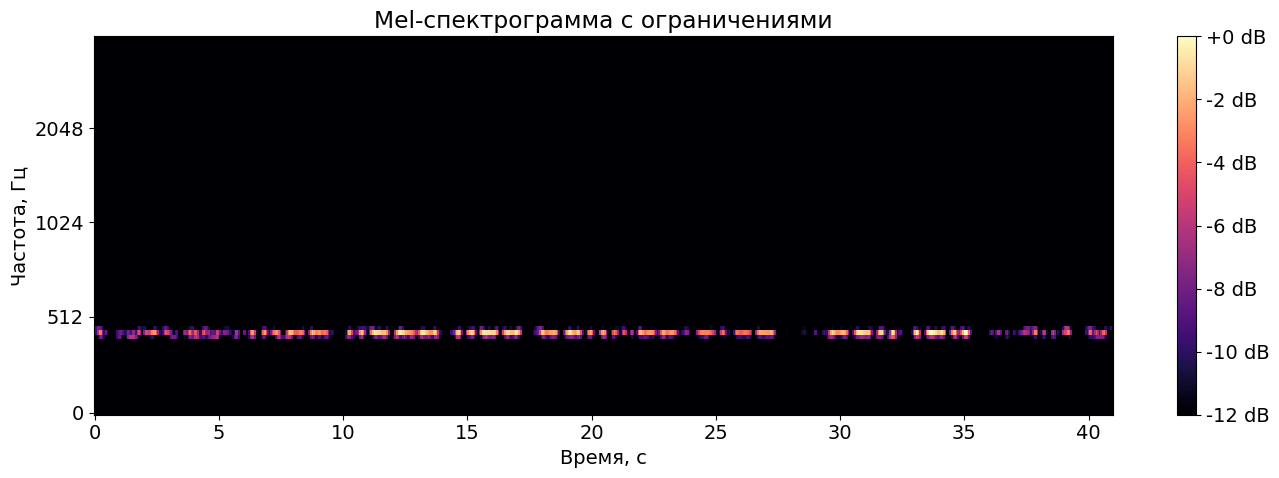

In [456]:
# Построение Mel-спектрограммы сигнала с ограничением
plt.figure(figsize=(14, 5))
S = librosa.feature.melspectrogram(y=np.array(normalized_waveform), sr=sample_rate, n_mels=100, n_fft=600, hop_length=100)
S_dB = librosa.power_to_db(S, ref=np.max, amin=1e-6, top_db=12)
S_dB[S_dB < -12] = -12  # обрезаем всё ниже -40 дБ
# S_dB = (S_dB - S_dB.min()) / (S_dB.max() - S_dB.min())  # Нормализация
librosa.display.specshow(S_dB, sr=sample_rate, x_axis="time", y_axis="mel")

plt.colorbar(format="%+2.0f dB")
plt.title("Mel-спектрограмма с ограничениями")
plt.xlabel("Время, с")
plt.ylabel("Частота, Гц")

plt.tight_layout()
plt.show()

In [54]:
S_dB.shape

(100, 86)

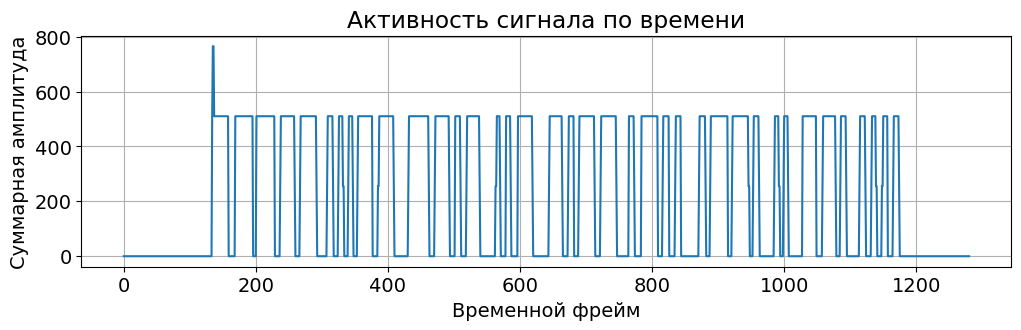

Макс активность: 1.0
Порог: 0.3
Сколько активных фреймов: 643


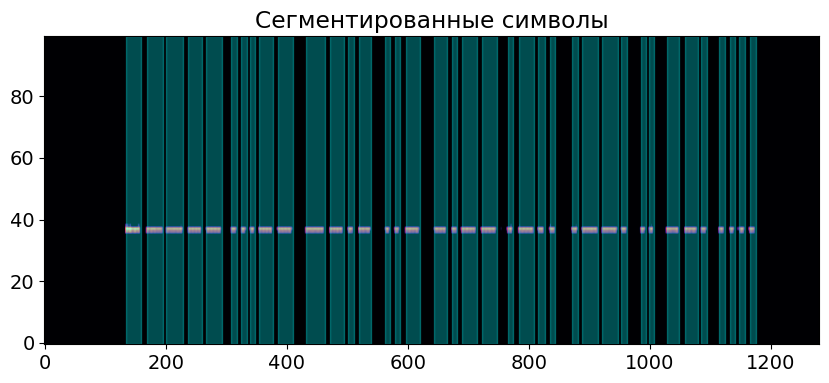

In [109]:
S_img = (S_dB * 255).astype(np.uint8)

# 2. Инвертируем (чтобы сигнал был белым, фон — чёрным)
_, binary = cv2.threshold(S_img, 90, 255, cv2.THRESH_BINARY)

# 3. Суммируем по частоте, чтобы получить активность по времени
time_activity = np.sum(binary, axis=0)

plt.figure(figsize=(12, 3))
plt.plot(time_activity)
plt.title("Активность сигнала по времени")
plt.xlabel("Временной фрейм")
plt.ylabel("Суммарная амплитуда")
plt.grid(True)
plt.show()

# 4. Нормализуем и сгладим
norm_activity = time_activity / np.max(time_activity)
smoothed = cv2.GaussianBlur(norm_activity, (15, 1), 0)

# 5. Выделим "активные" области
threshold = 0.3
active = smoothed > threshold

print("Макс активность:", np.max(smoothed))
print("Порог:", threshold)
print("Сколько активных фреймов:", np.sum(smoothed > threshold))

# 6. Поиск сегментов
segments = []
start = None
for i, val in enumerate(active):
    if val and start is None:
        start = i
    elif not val and start is not None:
        if i - start > 3:  # Минимальная длина символа в фреймах
            segments.append((start, i))
        start = None

# 7. Визуализация найденных сегментов (опционально)
plt.figure(figsize=(10, 4))
plt.imshow(S_dB, origin='lower', aspect='auto', cmap='magma')
for x1, x2 in segments:
    plt.axvspan(x1, x2, color='cyan', alpha=0.3)
plt.title("Сегментированные символы")
plt.show()

## Посимвольная классификация (`librosa` + классификатор)

In [11]:
# Константы

# Директория с аудиосигналами
FILES_DIR = "morse_dataset/morse_dataset"

# Вычисление доминантной частоты
FMIN = 0
FMAX = 4000

# Загрузка аудиофайлов
SAMPLE_RATE = 8000

# Спектральное шумоподавление
N_FFT_SNR = 2048
HOP_LENGTH_SNR = 512
NOISE_FRAMES = 5

# Жесткая фильтрация и обрезка концов
START_END_THRESHOLD = 0.3
CUTOFF_SIZE = 140

# Нормализация
FRAME_LENGTH = 4096
HOP_LENGTH_RMS = 2048
TARGET_RMS = 0.95
GAIN = 4.0

# Разделение на побуквенные сигналы
AMPL_THRESHOLD = 0.56
TIME_THRESHOLD = 784
BLANK_THRESHOLD = 2500

# Директория с посимвольными записями
LETTERS_DIR = "morse_dataset/letters_dataset"

# Построение финальной спектрограммы
N_FFT_SPEC = 600
HOP_LENGTH_SPEC = 100
N_MELS = 100
TOP_DB = 12
AMIN = 1e-6
MIN_AMP = -12

# Обучение модели
NUM_CLASSES = 45
EPOCHS = 5
LEARNING_RATE = 5e-4
BATCH_SIZE = 32
DEVICE = torch.device("mps" if torch.backends.mps.is_available() 
                      else "cuda" if torch.cuda.is_available() 
                      else "cpu")

In [ ]:
# Построение спектрограммы
def loadAudio(path):
    waveform, _ = librosa.load(path, sr=SAMPLE_RATE)
    return waveform

def dominantFreq(wf_path, fmin=FMIN, fmax=FMAX):
    waveform = loadAudio(wf_path)

    S = librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=192, n_fft=768, hop_length=96)
    S_dB = librosa.power_to_db(S, ref=np.max)
    mel_sums = np.sum(S_dB, axis=1)
    max_idx = np.argmax(mel_sums)
    mel_frequencies = librosa.mel_frequencies(n_mels=S_dB.shape[0], fmin=fmin, fmax=fmax)
    dominant_freq = mel_frequencies[max_idx]    

    return dominant_freq

def spectralNR(wf_path, n_fft=N_FFT_SNR, hop_length=HOP_LENGTH_SNR, noise_frames=NOISE_FRAMES):
    waveform = loadAudio(wf_path)

    S = librosa.stft(waveform, n_fft=n_fft, hop_length=hop_length)
    magnitude, phase = np.abs(S), np.angle(S)

    # Оценка шума по числу фреймов
    noise_profile = np.mean(magnitude[:, :noise_frames], axis=1, keepdims=True)

    # Вычитание шума
    magnitude_denoised = np.maximum(magnitude - noise_profile, 0)

    # Восстановление сигнала
    S_denoised = magnitude_denoised * np.exp(1j * phase)
    waveform_denoised = librosa.istft(S_denoised, hop_length=hop_length)

    return waveform_denoised

def filtrate(wf_path, th=START_END_THRESHOLD, cutoff_size=CUTOFF_SIZE):
    waveform = spectralNR(wf_path)
    # Преобразование Фурье
    signal = waveform / np.max(np.abs(waveform))
    N = len(signal)

    yf = fourier.fft(signal)
    magnitude = np.abs(yf[:N//2]) / N

    max_amp = np.argmax(magnitude)
    magnitude_filt = [magnitude[i] if (max_amp - cutoff_size) < i < (max_amp + cutoff_size) 
                    else 0 for i in range(len(magnitude))]

    yf_filt = np.zeros_like(yf, dtype=complex)

    for i in range(len(magnitude_filt)):
        yf_filt[i] = yf[i] if magnitude_filt[i] != 0 else 0

    for i in range(1, len(magnitude_filt)):
        yf_filt[-i] = np.conj(yf_filt[i])

    # Обратное преобразование Фурье
    filtered_signal = np.real(fourier.ifft(yf_filt))

    # Алгоритм для обрезки начала и конца
    l, r = 0, len(filtered_signal) - 1
    while l < len(filtered_signal):
        if filtered_signal[l] < th:
            filtered_signal[l] = 0
            start = l
        else:
            break
        l += 1

    while r > 0:
        if filtered_signal[r] < th:
            filtered_signal[r] = 0
            end = r
        else:
            break
        r -= 1

    return filtered_signal, start, end

def normalize(wf_path, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH_RMS, target_rms=TARGET_RMS, gain=GAIN):
    waveform, s, e = filtrate(wf_path)
    start = s; end = e
    # RMS-нормализация
    rms = librosa.feature.rms(y=waveform, frame_length=frame_length, hop_length=hop_length)[0]
    gain_rms = target_rms / (rms + 1e-12)
    gain_rms = np.clip(gain_rms, 2.0, 3.5)  # Ограничение

    # Применим gain покадрово
    y_rms = np.zeros_like(waveform)
    for i in range(len(rms)):
        start = i * hop_length
        end = start + frame_length
        y_rms[start:end] += waveform[start:end] * gain_rms[i]
    y_rms = 2 * (y_rms - y_rms.min()) / (y_rms.max() - y_rms.min()) - 1

    # Нормализация громкости
    signal_tensor = torch.tensor(y_rms, dtype=torch.float32)
    tf = ta.transforms.Vol(gain=gain, gain_type='db')
    waveform_normalized = tf(signal_tensor)
    waveform_normalized = np.array(waveform_normalized)

    envelope, _ = get_envelope(np.array(normalized_waveform), 8000)

    return waveform_normalized, s, e, envelope

def LBLDivide(wf_path, ampl_threshold=AMPL_THRESHOLD, time_threshold=TIME_THRESHOLD, blank_threshold=BLANK_THRESHOLD):
    waveform, start, end, envelope = normalize(wf_path)
    divisions = []  # Список разделителей

    # thr = otsu_threshold(envelope)
    # ampl_threshold = thr

    curr_pause = 0
    flag = []  # Вспомогательный список для обозначения пробелов

    l = start + 1  # Указатель на первый пик
    while l <= end - 1:
        if waveform[l] < ampl_threshold:
            flag.append(l)
            curr_pause += 1
            if waveform[l + 1] > ampl_threshold:
                if curr_pause >= time_threshold:
                    divisions.append(l - 400)
                    if curr_pause >= blank_threshold:
                        divisions.append(flag[0] + 100)
                curr_pause = 0
                flag = []
        l += 1
    
    # # Добавление начала и конца (со сдвигом)
    divisions = sorted([start - 100] + divisions + [end + 100])

    return waveform, divisions

letters_train = pd.DataFrame({
        'id': [],
        'letter': []
    })

def lettersTrainMaking(train_df):
    for i in range(len(train_df)):
        waveform, divisions = LBLDivide(f"{FILES_DIR}/{train_df['id'][i]}")
        print(divisions)
        if (len(divisions) - 1) == len(train_df['message'][i]):
            for p in range(len(divisions) - 1):
                sf.write(f"{LETTERS_DIR}/{(train_df['id'][i])[:-5]}_{p + 1}.wav", 
                        waveform[divisions[p]:divisions[p + 1]], samplerate=SAMPLE_RATE)
                letters_train.loc[len(letters_train)] = [f"{(train_df['id'][i])[:-5]}_{p + 1}.wav", train_df['message'][i][p]]
    
    letters_train.to_csv("letters_train.csv", index=False)
    print("Dataset saved successfully.")

def computeMelSpectrogram(wf_path, sr=SAMPLE_RATE, n_fft=N_FFT_SPEC, hop_length=HOP_LENGTH_SPEC, n_mels=N_MELS, 
                          top_db=TOP_DB, amin=AMIN, min_amp=MIN_AMP):
    waveform = loadAudio(wf_path)

    S = librosa.feature.melspectrogram(
        y=waveform,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    S_dB = librosa.power_to_db(S, ref=np.max, top_db=top_db, amin=amin)
    S_dB[S_dB < min_amp] = min_amp
    return S_dB

In [366]:
os.makedirs(LETTERS_DIR, exist_ok=True)

In [372]:
lettersTrainMaking(train_df=train_dataframe)

[6531, 14947, 20991, 27687, 31740, 37727, 43098, 48784, 50895, 55228, 58823]
[8945, 16389, 21628, 24023, 31649, 35641, 38881, 44333, 47507, 53570, 57884]
[12195, 22614, 27709, 34213, 39049, 44537, 49059, 54660, 57473]
[9728, 21536, 26623, 34579, 47235, 52321, 56692]
[9788, 15451, 21998, 27490, 43032, 45445, 50925, 55105]
[742, 11573, 36965, 42509, 49417]
[7640, 18532, 25486, 32791, 42359, 48199, 56073]
[7959, 12610, 15473, 19869, 24508, 27144, 30696, 35976, 39960, 42307, 46134, 49004, 53633, 54627]
[4702, 8292, 13045, 18565, 23682, 29261, 34196, 38623, 43605, 48803, 53644, 56584, 59122]
[6490, 12501, 18880, 23860, 27278, 33058, 48077, 57232, 58328]
[504, 1743, 5434, 7769, 10063, 16166, 18793, 22203, 24106, 29893, 33813, 35197, 37866, 44220, 49694, 51525, 53841, 56748]
[4747, 9704, 17836, 23592, 28280, 37208, 43379, 50056, 55103]
[13804, 20493, 25252, 29581, 34496, 37129, 42937, 51640, 58667]
[18603, 32010, 34953, 36666, 41614, 45817, 52845]
[10938, 17091, 24329, 30490, 33144, 38648, 42

In [373]:
letters_train.to_csv('letters_train.csv', index=False)
letters_train

id letter
0           1_1.wav      0
1           1_2.wav      3
2           1_3.wav      Щ
3           1_4.wav      У
4           1_5.wav      Ы
...             ...    ...
140430  29999_3.wav      Д
140431  29999_4.wav      Ш
140432  29999_5.wav      3
140433  29999_6.wav      Т
140434  29999_7.wav      #

[140435 rows x 2 columns]

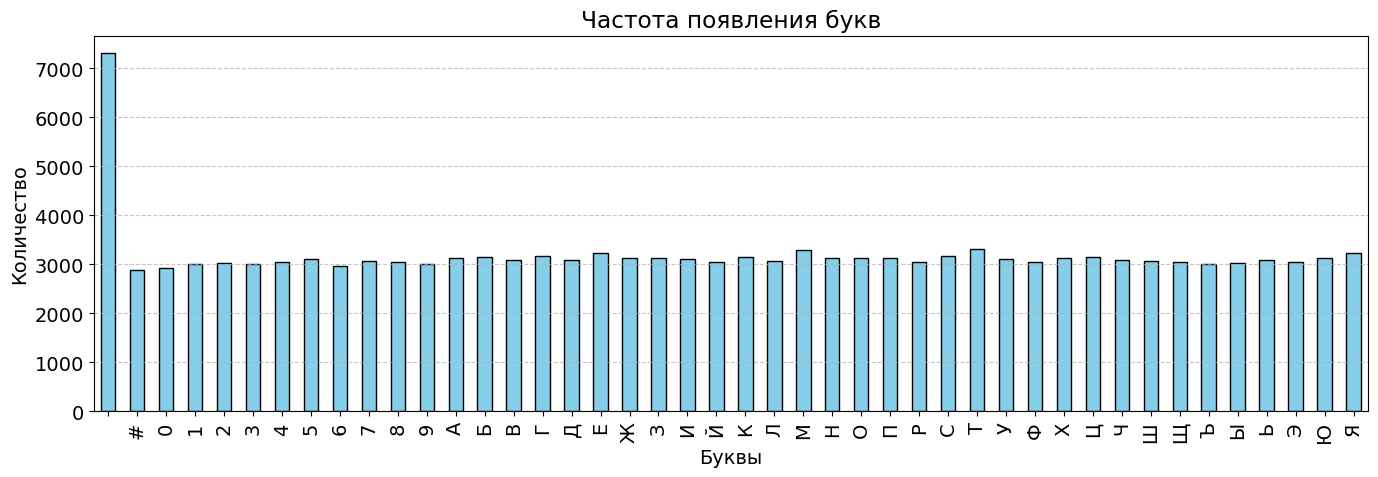

In [374]:
letter_counts = letters_train['letter'].value_counts().sort_index()  # можно .sort_values() если нужно по убыванию

# Построение графика
plt.figure(figsize=(14, 5))
letter_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Частота появления букв')
plt.xlabel('Буквы')
plt.ylabel('Количество')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [375]:
# Undersampling для сэмплирования преобладающего класса до размера, эквивалетного остальным
min_class_size = letter_counts[letter_counts.index != ' '].min() + 200

# Разделение датафрейма
df_others = letters_train[letters_train['letter'] != ' ']
df_hash = letters_train[letters_train['letter'] == ' ']

# Сэмплируем # до min_class_size
df_hash_sampled = df_hash.sample(n=min_class_size, random_state=42)

# Находим удаляемые строки (избыточные #)
df_hash_to_remove = df_hash.drop(df_hash_sampled.index)

# Удаляем файлы, соответствующие этим строкам
for file_id in df_hash_to_remove['id']:
    file_path = os.path.join(LETTERS_DIR, file_id)
    if os.path.exists(file_path):
        os.remove(file_path)

# Собираем сбалансированный датасет
df_balanced = pd.concat([df_others, df_hash_sampled]).sample(frac=1, random_state=42)

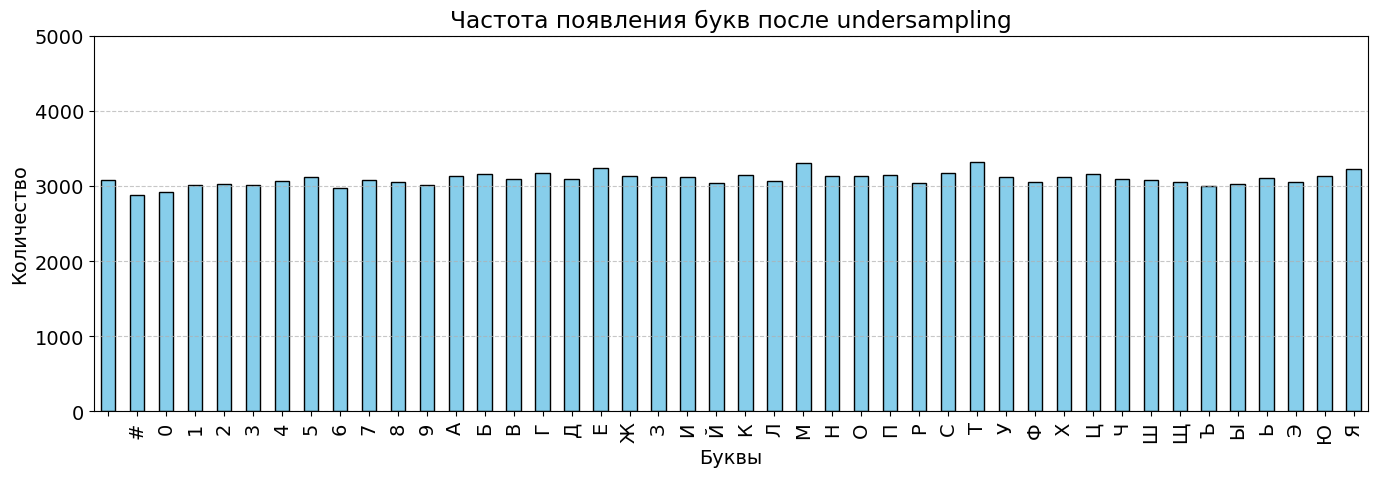

In [376]:
letter_counts_balanced = df_balanced['letter'].value_counts().sort_index()

# Построение графика после процедуры undersampling
plt.figure(figsize=(14, 5))
letter_counts_balanced.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Частота появления букв после undersampling')
plt.xlabel('Буквы')
plt.ylabel('Количество')
plt.ylim([0, 5000])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [377]:
# Реализация класса LettersDataset для создания датасета
class LettersDataset(Dataset):
    def __init__(self, df, audio_dir, label_map, target_size=(100, 64)):
        """
        df: DataFrame с колонками 'id' (имя файла без пути) и 'letter' (символ класса)
        audio_dir: путь к директории с аудиофайлами
        target_size: размер выходной спектрограммы (высота, ширина) = (time, freq)
        label_map: dict {"А": 0, "Б": 1, ..., "#": 45}. Если None — создается автоматически.
        """
        self.df = df
        self.audio_dir = audio_dir
        self.target_size = target_size  # (H, W)
        self.label_map = label_map

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row["id"]
        letter = row["letter"]

        path = f"{self.audio_dir}/{filename}"
        spec = computeMelSpectrogram(wf_path=path)  # numpy-массив (H, W)

        # resize: (H, W) → (target_H, target_W)
        resized_spec = cv2.resize(spec, dsize=(self.target_size[1], self.target_size[0]), interpolation=cv2.INTER_LINEAR)

        # → [1, H, W] в формате torch.tensor
        x = torch.tensor(resized_spec, dtype=torch.float32).unsqueeze(0)
        y = torch.tensor(self.label_map[letter], dtype=torch.long)

        return x, y

In [378]:
# Реализация класса модели MorseDecodingModel
class MorseDecodingModel(nn.Module):
    def __init__(self, num_classes):
        super(MorseDecodingModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),   # [1, 100, 64] -> [16, 100, 64]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                           # -> [16, 50, 32]

            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # -> [32, 50, 32]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                           # -> [32, 25, 16]

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # -> [64, 25, 16]
            nn.LeakyReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2, 2),                           # -> [64, 12, 8]
        )

        self.classifier = nn.Sequential(
            nn.Linear(64 * 12 * 8, 128),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)                     # [batch_size, 64, 12, 8]
        x = x.view(x.size(0), -1)                # [batch_size, 6144]
        x = self.classifier(x)                   # [batch_size, num_classes]
        return x

In [379]:
def fit(model, criterion, optimizer, train_loader, val_loader, num_epochs, device):
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for x_batch, y_batch in tqdm(train_loader, desc="[Training]"):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x_batch.size(0)
            _, preds = outputs.max(1)
            train_correct += preds.eq(y_batch).sum().item()
            train_total += y_batch.size(0)

        train_loss /= train_total
        train_acc = train_correct / train_total * 100

        # Валидация
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for x_val, y_val in tqdm(val_loader, desc="[Validation]"):
                x_val, y_val = x_val.to(device), y_val.to(device)
                outputs = model(x_val)
                loss = criterion(outputs, y_val)

                val_loss += loss.item() * x_val.size(0)
                _, preds = outputs.max(1)
                val_correct += preds.eq(y_val).sum().item()
                val_total += y_val.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total * 100

        print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}% "
              f"|| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Сохраняем модель
    torch.save(model.state_dict(), "test_weights_CNN.pth")

In [380]:
letters_train = df_balanced
letters_train.head()

id letter
14977   3275_7.wav      Х
8726    1961_4.wav      З
80579  17246_3.wav      6
74318  15956_5.wav      Ю
29334   6446_6.wav      О

In [381]:
# Создание словаря меток
letters = sorted(letters_train["letter"].unique())
label_map = {letter: idx for idx, letter in enumerate(letters)}
inv_label_map = {idx: letter for idx, letter in enumerate(letters)}

# Разделение на train и validation (10% для валидации)
train_data, val_data = train_test_split(letters_train, test_size=0.1, random_state=42)

# Создание экземпляров классов Dataset и DataLoader
train_dataset = LettersDataset(df=train_data, audio_dir=LETTERS_DIR, label_map=label_map)
val_dataset = LettersDataset(df=val_data, audio_dir=LETTERS_DIR, label_map=label_map)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [382]:
# Модель
model = MorseDecodingModel(num_classes=NUM_CLASSES)

In [383]:
# Создания лосс-критерия и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [384]:
print(f"Device for fitting and predicting: {DEVICE}")

Device for fitting and predicting: mps


In [385]:
# Обучение
fit(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=EPOCHS,
    device=DEVICE)

[Validation]: 100%|██████████| 426/426 [00:36<00:00, 11.78it/s]


[Epoch 1] Train Loss: 0.9988 | Acc: 77.39% || Val Loss: 0.4528 | Val Acc: 91.66%


[Validation]: 100%|██████████| 426/426 [00:41<00:00, 10.33it/s]


[Epoch 2] Train Loss: 0.4730 | Acc: 91.44% || Val Loss: 0.3984 | Val Acc: 92.69%


[Validation]: 100%|██████████| 426/426 [00:37<00:00, 11.41it/s]


[Epoch 3] Train Loss: 0.4225 | Acc: 92.35% || Val Loss: 0.3874 | Val Acc: 93.14%


[Validation]: 100%|██████████| 426/426 [00:37<00:00, 11.23it/s]


[Epoch 4] Train Loss: 0.3932 | Acc: 92.77% || Val Loss: 0.3899 | Val Acc: 93.10%


[Validation]: 100%|██████████| 426/426 [00:42<00:00, 10.00it/s]

[Epoch 5] Train Loss: 0.3724 | Acc: 93.06% || Val Loss: 0.3706 | Val Acc: 93.44%


In [394]:
def computeMSInference(waveform, sr=SAMPLE_RATE, n_fft=N_FFT_SPEC, hop_length=HOP_LENGTH_SPEC, n_mels=N_MELS, 
                          top_db=TOP_DB, amin=AMIN, min_amp=MIN_AMP):
    S = librosa.feature.melspectrogram(
        y=waveform,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    S_dB = librosa.power_to_db(S, ref=np.max, top_db=top_db, amin=amin)
    S_dB[S_dB < min_amp] = min_amp
    return S_dB

def inference(model, test_df, audio_dir, inv_label_map, device, target_size=(100, 64)):
    """
    model: обученная модель
    test_csv: путь к CSV файлу с данными для предсказания (должен содержать столбец 'id')
    audio_dir: путь к директории с аудиофайлами
    label_map: словарь меток (буквы → индексы)
    inv_label_map: обратный словарь меток (индексы → буквы)
    device: устройство ('cuda' или 'cpu')
    
    Возвращает DataFrame с результатами предсказаний для каждого файла.
    """
    model.to(device)
    model.eval()

    results = []

    # Обрабатываем каждый файл из тестового набора
    for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="[Inferencing]"):
        filename = row['id']
        file_path = os.path.join(audio_dir, filename)

        # Разделяем аудиофайл на сегменты побуквенно
        waveform, divisions = LBLDivide(file_path)  # Функция, которая делит сигнал на буквы

        decoded_message = []

        # Обрабатываем каждый сегмент
        for i in range(len(divisions) - 1):
            # Генерация спектрограммы для каждого сегмента
            S = computeMSInference(waveform=waveform[divisions[i]:divisions[i + 1]])  # numpy массив (H, W)

            # Приводим спектрограмму к размеру (1, 100, 64)
            resized_S = cv2.resize(S, dsize=(target_size[1], target_size[0]), interpolation=cv2.INTER_LINEAR)
            S_tensor = torch.tensor(resized_S, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

            # Инференс
            with torch.no_grad():
                output = model(S_tensor)  # Предсказание для текущего сегмента

            # Получаем индекс класса с максимальной вероятностью
            predicted_class = output.argmax(dim=1).item()

            # Декодируем индекс обратно в символ
            predicted_letter = inv_label_map[predicted_class]
            decoded_message.append(predicted_letter)

        # Склеиваем все буквы в строку
        decoded_message = ''.join(decoded_message)
        results.append({'id': filename, 'message': decoded_message})

    # Возвращаем DataFrame с результатами
    return pd.DataFrame(results)

In [ ]:
model = MorseDecodingModel(num_classes=NUM_CLASSES)
model.load_state_dict(torch.load("test_weights_CNN.pth"))
model.to(DEVICE)

predictions_df = inference(
    model=model,
    test_df=test_dataframe,  # путь к файлу test.csv
    audio_dir=FILES_DIR,  # путь к директории с файлами
    inv_label_map=inv_label_map,  # обратный словарь меток
    device=DEVICE
)

# predictions_df_train = inference(
#     model=model,
#     test_df=train_dataframe[5200:7700],  # путь к файлу test.csv
#     audio_dir=FILES_DIR,  # путь к директории с файлами
#     inv_label_map=inv_label_map,  # обратный словарь меток
#     device=DEVICE
# )

[Inferencing]: 100%|██████████| 5000/5000 [14:33<00:00,  5.73it/s]


In [404]:
targets = list(train_dataframe['message'][5200:7700])
targets

['6УАИЦ Ф19О',
 'ДФРГС776Д',
 'ЩДПТ ЙКЦ7',
 'ЩБЧТЪЩ5ЩЛ',
 '6ЭЛЯФ0З44',
 'Ц1ЩМ8ГЕЗНЦН',
 '8Г4МАЫ8АЖ',
 'ОЙ96ИИШАБК',
 'ШХФ Д110Ь',
 'РГЦ7Г73Ь',
 '934РЮТФ2Ь',
 'М3П7ЩХЩ',
 'ЬЦОЗ2ЦЦКЮ',
 'А 35ГШК',
 'Ч 6КТ#ВП',
 'ЪЫ 6КО 3',
 'УУЩМД2ЯЦШ',
 'Х ПЮ#3ЗП6',
 '#ЩЗБЛМЬ',
 '8Щ64М0Р',
 'ТДЯШШЕН6ОС З',
 'ЙЭЙФВВ5',
 'УСФК9ХЭШЗИ',
 'Ц5Х2П39',
 'ЮЙХ5Ц#ЛЛЧА',
 'ПЭК ЮСЫЮ',
 '#67ЭМОЮ',
 'ЧЧ8ШАЙ Ж',
 'ОЮКЬЖЪ',
 'Ш7КА3ПН6Р',
 'ВЙШЛОЕ0Л',
 'А#Т##ЙЮ',
 '2ПИ#Й 5Й',
 '8ЙЧРЮ6',
 '5П11ЙЪ#АО',
 '7Б86П ПХ',
 'ПЭЕ9ОЮП6 3',
 'ТР 7Ь БХЕ5ЫБ',
 'ФЧНЪА66',
 'ШЕ4ТЯАЩВ0Ж',
 'ХЖ5Н8СФШ',
 '4Ц К5Т7Д#',
 'КМЯТЛ2ПЙ',
 'ЙБПСД4ГШ 5',
 'ЧНСС8ЮМХСОЮА',
 'ШПЬЖУС2ЕЩ',
 'ШЕЦ4ЮОЦА',
 'ЕМЙЛАЫЮПХД',
 '6КЧС992',
 'Ч17 ЬЛ Р9',
 'ХХЙВ6УЫ5 НГ',
 '3Т ЪГИВМХЕЧП',
 'Й18ЦЦ6Ю2',
 'ХАУЧ1#',
 '8ОКЗЖЖЧМ4',
 'КЩ1ЬЙВК27',
 'Ж ЕЩ4К1 ЩК#',
 'Ы У8ЪТ2Ф4',
 'ИФЧ6УЮЯЯЭЖ',
 '2Г#УИБИ',
 'Ю2ГИОСФЯ',
 'Щ КИЧР5ЦСЛ5',
 'ИХФЯНЫФК8ЦИА',
 'ЦЕЭМИФЯЮ5Б',
 'ХБЦВЙ ЭАОХ',
 '4ЛСТ6ГСБЮ',
 'МЭ3З ДСЩ1',
 'СЪТХ4ЖЖЩГС',
 'КЧШСГФ3С',
 'ЬАЦНР3 З',
 'ПЛФ9Ь2',
 'ЮЕГЯЖСМЛ',
 'Й#РМО

In [390]:
# Функция для подсчета метрики Levenshtein Mean
def levenshteinMean(predictions, targets):
    assert len(predictions) == len(targets), "Списки должны быть одинаковой длины"

    distances = [Levenshtein.distance(pred, tgt) for pred, tgt in zip(predictions, targets)]
    return sum(distances) / len(distances)

In [405]:
levenshteinMean(list(predictions_df_train['message']), targets)

1.6428

In [407]:
predictions_df.to_csv('prediction.csv', index=False)

## CNN + CTCLoss

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from typing import Tuple, List, Dict
import torch.nn.functional as F

# Предполагаем, что у нас есть функция для вычисления спектрограммы
# def computeMelSpectrogram(path: str) -> np.ndarray: ...

# Словарь для преобразования символов в индексы
char_to_index = {
    # Русские заглавные буквы
    'А': 0, 'Б': 1, 'В': 2, 'Г': 3, 'Д': 4, 'Е': 5, 'Ж': 6, 'З': 7, 'И': 8, 'Й': 9,
    'К': 10, 'Л': 11, 'М': 12, 'Н': 13, 'О': 14, 'П': 15, 'Р': 16, 'С': 17, 'Т': 18, 
    'У': 19, 'Ф': 20, 'Х': 21, 'Ц': 22, 'Ч': 23, 'Ш': 24, 'Щ': 25, 'Ъ': 26, 'Ы': 27, 
    'Ь': 28, 'Э': 29, 'Ю': 30, 'Я': 31,
    
    # Цифры
    '0': 32, '1': 33, '2': 34, '3': 35, '4': 36,
    '5': 37, '6': 38, '7': 39, '8': 40, '9': 41,
    
    # Специальные символы
    '#': 42, ' ': 43,
    
    # Символ blank для CTC (должен быть последним)
    '-': 44  # blank для CTC
}
index_to_char = {v: k for k, v in char_to_index.items()}

def loadAudio(path):
    waveform, _ = librosa.load(path, sr=SAMPLE_RATE)
    return waveform

def dominantFreq(wf_path, fmin=FMIN, fmax=FMAX):
    waveform = loadAudio(wf_path)

    S = librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=192, n_fft=768, hop_length=96)
    S_dB = librosa.power_to_db(S, ref=np.max)
    mel_sums = np.sum(S_dB, axis=1)
    max_idx = np.argmax(mel_sums)
    mel_frequencies = librosa.mel_frequencies(n_mels=S_dB.shape[0], fmin=fmin, fmax=fmax)
    dominant_freq = mel_frequencies[max_idx]    

    return dominant_freq

def spectralNR(wf_path, n_fft=N_FFT_SNR, hop_length=HOP_LENGTH_SNR, noise_frames=NOISE_FRAMES):
    waveform = loadAudio(wf_path)

    S = librosa.stft(waveform, n_fft=n_fft, hop_length=hop_length)
    magnitude, phase = np.abs(S), np.angle(S)

    # Оценка шума по числу фреймов
    noise_profile = np.mean(magnitude[:, :noise_frames], axis=1, keepdims=True)

    # Вычитание шума
    magnitude_denoised = np.maximum(magnitude - noise_profile, 0)

    # Восстановление сигнала
    S_denoised = magnitude_denoised * np.exp(1j * phase)
    waveform_denoised = librosa.istft(S_denoised, hop_length=hop_length)

    return waveform_denoised

def filtrate(wf_path, th=START_END_THRESHOLD, cutoff_size=CUTOFF_SIZE):
    waveform = spectralNR(wf_path)
    # Преобразование Фурье
    signal = waveform / np.max(np.abs(waveform))
    N = len(signal)

    yf = fourier.fft(signal)
    magnitude = np.abs(yf[:N//2]) / N

    max_amp = np.argmax(magnitude)
    magnitude_filt = [magnitude[i] if (max_amp - cutoff_size) < i < (max_amp + cutoff_size) 
                    else 0 for i in range(len(magnitude))]

    yf_filt = np.zeros_like(yf, dtype=complex)

    for i in range(len(magnitude_filt)):
        yf_filt[i] = yf[i] if magnitude_filt[i] != 0 else 0

    for i in range(1, len(magnitude_filt)):
        yf_filt[-i] = np.conj(yf_filt[i])

    # Обратное преобразование Фурье
    filtered_signal = np.real(fourier.ifft(yf_filt))

    # Алгоритм для обрезки начала и конца
    l, r = 0, len(filtered_signal) - 1
    while l < len(filtered_signal):
        if filtered_signal[l] < th:
            filtered_signal[l] = 0
            start = l
        else:
            break
        l += 1

    while r > 0:
        if filtered_signal[r] < th:
            filtered_signal[r] = 0
            end = r
        else:
            break
        r -= 1

    return filtered_signal, start, end

def normalize(wf_path, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH_RMS, target_rms=TARGET_RMS, gain=GAIN):
    waveform, s, e = filtrate(wf_path)
    start = s; end = e
    # RMS-нормализация
    rms = librosa.feature.rms(y=waveform, frame_length=frame_length, hop_length=hop_length)[0]
    gain_rms = target_rms / (rms + 1e-12)
    gain_rms = np.clip(gain_rms, 2.2, 3.5)  # Ограничение

    # Применим gain покадрово
    y_rms = np.zeros_like(waveform)
    for i in range(len(rms)):
        start = i * hop_length
        end = start + frame_length
        y_rms[start:end] += waveform[start:end] * gain_rms[i]
    y_rms = 2 * (y_rms - y_rms.min()) / (y_rms.max() - y_rms.min()) - 1

    # Нормализация громкости
    signal_tensor = torch.tensor(y_rms, dtype=torch.float32)
    tf = ta.transforms.Vol(gain=gain, gain_type='db')
    waveform_normalized = tf(signal_tensor)
    waveform_normalized = np.array(waveform_normalized)

    return waveform_normalized

def computeMelSpectrogram(wf_path, sr=SAMPLE_RATE, n_fft=N_FFT_SPEC, hop_length=HOP_LENGTH_SPEC, n_mels=N_MELS, 
                          top_db=TOP_DB, amin=AMIN, min_amp=MIN_AMP):
    waveform = normalize(wf_path)

    S = librosa.feature.melspectrogram(
        y=waveform,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    S_dB = librosa.power_to_db(S, ref=np.max, top_db=top_db, amin=amin)
    S_dB[S_dB < min_amp] = min_amp
    return S_dB

class MorseDataset(Dataset):
    def __init__(self, file_paths: List[str], labels: List[str], max_spectrogram_width: int = 100):
        """
        file_paths: список путей к аудиофайлам
        labels: список соответствующих меток (последовательности символов)
        max_spectrogram_width: максимальная ширина спектрограммы (по времени)
        """
        self.file_paths = file_paths
        self.labels = labels
        self.max_spectrogram_width = max_spectrogram_width
        
    def __len__(self) -> int:
        return len(self.file_paths)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, int, int]:
        # Загружаем спектрограмму
        spectrogram = computeMelSpectrogram(self.file_paths[idx])
        
        # Приводим к нужному размеру (дополняем или обрезаем)
        if spectrogram.shape[1] > self.max_spectrogram_width:
            spectrogram = spectrogram[:, :self.max_spectrogram_width]
        else:
            pad_width = self.max_spectrogram_width - spectrogram.shape[1]
            spectrogram = np.pad(spectrogram, ((0, 0), (0, pad_width)), mode='constant')
        
        # Преобразуем метку в индексы
        label = self.labels[idx]
        target = torch.tensor([char_to_index[c] for c in label], dtype=torch.long)
        
        return torch.tensor(spectrogram, dtype=torch.float32).unsqueeze(0), target

def collate_fn(batch: List[Tuple[torch.Tensor, torch.Tensor]]) -> Dict[str, torch.Tensor]:
    """
    Пакетная обработка данных для CTC loss.
    Возвращает словарь с:
    - spectrograms: пакет спектрограмм
    - targets: объединенные целевые последовательности
    - input_lengths: длины спектрограмм
    - target_lengths: длины целевых последовательностей
    """
    spectrograms = []
    targets = []
    input_lengths = []
    target_lengths = []
    
    for spectrogram, target in batch:
        spectrograms.append(spectrogram)
        targets.append(target)
        input_lengths.append(spectrogram.size(1))  # Длина по времени
        target_lengths.append(len(target))
    
    spectrograms = torch.nn.utils.rnn.pad_sequence(spectrograms, batch_first=True)
    targets = torch.cat(targets)
    
    return {
        'spectrograms': spectrograms,
        'targets': targets,
        'input_lengths': torch.tensor(input_lengths, dtype=torch.long),
        'target_lengths': torch.tensor(target_lengths, dtype=torch.long)
    }

class MorseCNN(nn.Module):
    def __init__(self, num_classes: int = len(char_to_index)):
        super(MorseCNN, self).__init__()
        self.num_classes = num_classes
        
        # CNN часть
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)),
        )
        
        # Полностью связанные слои
        self.fc = nn.Sequential(
            nn.Linear(128 * 10, 128),  # 10 - примерная высота после CNN, нужно подобрать
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Применяем CNN
        x = self.cnn(x)
        
        # Переупорядочиваем размерности для fully connected
        batch_size, channels, height, time_steps = x.size()
        x = x.permute(0, 3, 2, 1)  # [batch, time, height, channels]
        x = x.reshape(batch_size, time_steps, -1)  # объединяем height и channels
        
        # Применяем fully connected
        x = self.fc(x)
        
        # Применяем log softmax для CTC
        x = F.log_softmax(x, dim=2)
        
        return x.permute(1, 0, 2)  # [time, batch, num_classes] для CTC

def fit(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer: optim.Optimizer,
    criterion: nn.CTCLoss,
    device: torch.device,
    epochs: int = 10,
    scheduler: optim.lr_scheduler._LRScheduler = None
) -> Tuple[List[float], List[float]]:
    """
    Обучение модели
    Возвращает списки потерь на обучении и валидации
    """
    train_losses = []
    val_losses = []
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        
        for batch in train_loader:
            spectrograms = batch['spectrograms'].to(device)
            targets = batch['targets'].to(device)
            input_lengths = batch['input_lengths'].to(device)
            target_lengths = batch['target_lengths'].to(device)
            
            optimizer.zero_grad()
            
            outputs = model(spectrograms)
            output_lengths = input_lengths // 4  # Примерное сокращение времени от CNN
            
            loss = criterion(outputs, targets, output_lengths, target_lengths)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Валидация
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                spectrograms = batch['spectrograms'].to(device)
                targets = batch['targets'].to(device)
                input_lengths = batch['input_lengths'].to(device)
                target_lengths = batch['target_lengths'].to(device)
                
                outputs = model(spectrograms)
                output_lengths = input_lengths // 4
                
                loss = criterion(outputs, targets, output_lengths, target_lengths)
                epoch_val_loss += loss.item()
        
        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        if scheduler:
            scheduler.step(avg_val_loss)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    return train_losses, val_losses

def inference(model: nn.Module, spectrogram: torch.Tensor, device: torch.device) -> str:
    """
    Предсказание символов по спектрограмме
    """
    model.to
    model.eval()
    with torch.no_grad():
        spectrogram = spectrogram.unsqueeze(0).to(device)
        output = model(spectrogram)
        
        # Применяем CTC декодирование (жадное)
        _, max_indices = torch.max(output, dim=2)
        max_indices = max_indices.squeeze(1).cpu().numpy()
        
        # Удаляем повторяющиеся символы и blank
        decoded = []
        prev_char = None
        for idx in max_indices:
            char = index_to_char[idx]
            if char != prev_char and char != '-':
                decoded.append(char)
            prev_char = char
        
        return ''.join(decoded)

# Пример использования
if __name__ == "__main__":
    train_data, val_data = train_test_split(train_dataframe, test_size=0.1, random_state=42)

    # Создание экземпляров классов Dataset и DataLoader
    train_dataset = MorseDataset(
        file_paths=FILES_DIR,
        labels=char_to_index
    )
    val_dataset = MorseDataset(
        file_paths=FILES_DIR,
        labels=char_to_index
    )

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn) 
    
    # Инициализация модели
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = MorseCNN().to(device)
    
    # Оптимизатор и функция потерь
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CTCLoss(blank=char_to_index['-'])  # blank символ
    
    # Планировщик скорости обучения
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.1)
    
    # Обучение
    train_losses, val_losses = fit(
        model,
        train_loader,
        val_loader,
        optimizer,
        criterion,
        device,
        epochs=20,
        scheduler=scheduler
    )
    
    # Сохранение модели
    torch.save(model.state_dict(), "morse_cnn_test.pth")
    
    # # Пример предсказания
    # test_file = "test.wav"
    # test_spectrogram = computeMelSpectrogram(test_file)
    # test_spectrogram = (test_spectrogram - test_spectrogram.mean()) / (test_spectrogram.std() + 1e-8)
    # test_spectrogram = torch.tensor(test_spectrogram, dtype=torch.float32).unsqueeze(0)
    
    # predicted = inference(model, test_spectrogram, device)
    # print(f"Predicted: {predicted}")

KeyError: 25

In [6]:
# Константы

# Директория с аудиосигналами
FILES_DIR = "morse_dataset/morse_dataset"

# Вычисление доминантной частоты
FMIN = 0
FMAX = 4000

# Загрузка аудиофайлов
SAMPLE_RATE = 8000

# Спектральное шумоподавление
N_FFT_SNR = 2048
HOP_LENGTH_SNR = 512
NOISE_FRAMES = 5

# Жесткая фильтрация и обрезка концов
START_END_THRESHOLD = 0.3
CUTOFF_SIZE = 140

# Нормализация
FRAME_LENGTH = 4096
HOP_LENGTH_RMS = 2048
TARGET_RMS = 0.95
GAIN = 4.0

# Разделение на побуквенные сигналы
AMPL_THRESHOLD = 0.56
TIME_THRESHOLD = 790
BLANK_THRESHOLD = 2500

# Директория с посимвольными записями
LETTERS_DIR = "morse_dataset/letters_dataset"

# Построение финальной спектрограммы
N_FFT_SPEC = 600
HOP_LENGTH_SPEC = 100
N_MELS = 100
TOP_DB = 12
AMIN = 1e-6
MIN_AMP = -12

# Обучение модели
NUM_CLASSES = 45
EPOCHS = 5
LEARNING_RATE = 5e-4
BATCH_SIZE = 32
DEVICE = torch.device("mps" if torch.backends.mps.is_available() 
                      else "cuda" if torch.cuda.is_available() 
                      else "cpu")

In [7]:
# Построение спектрограммы
def loadAudio(path):
    waveform, _ = librosa.load(path, sr=SAMPLE_RATE)
    return waveform

def dominantFreq(wf_path, fmin=FMIN, fmax=FMAX):
    waveform = loadAudio(wf_path)

    S = librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=192, n_fft=768, hop_length=96)
    S_dB = librosa.power_to_db(S, ref=np.max)
    mel_sums = np.sum(S_dB, axis=1)
    max_idx = np.argmax(mel_sums)
    mel_frequencies = librosa.mel_frequencies(n_mels=S_dB.shape[0], fmin=fmin, fmax=fmax)
    dominant_freq = mel_frequencies[max_idx]    

    return dominant_freq

def spectralNR(wf_path, n_fft=N_FFT_SNR, hop_length=HOP_LENGTH_SNR, noise_frames=NOISE_FRAMES):
    waveform = loadAudio(wf_path)

    S = librosa.stft(waveform, n_fft=n_fft, hop_length=hop_length)
    magnitude, phase = np.abs(S), np.angle(S)

    # Оценка шума по числу фреймов
    noise_profile = np.mean(magnitude[:, :noise_frames], axis=1, keepdims=True)

    # Вычитание шума
    magnitude_denoised = np.maximum(magnitude - noise_profile, 0)

    # Восстановление сигнала
    S_denoised = magnitude_denoised * np.exp(1j * phase)
    waveform_denoised = librosa.istft(S_denoised, hop_length=hop_length)

    return waveform_denoised

def filtrate(wf_path, th=START_END_THRESHOLD, cutoff_size=CUTOFF_SIZE):
    waveform = spectralNR(wf_path)
    # Преобразование Фурье
    signal = waveform / np.max(np.abs(waveform))
    N = len(signal)

    yf = fourier.fft(signal)
    magnitude = np.abs(yf[:N//2]) / N

    max_amp = np.argmax(magnitude)
    magnitude_filt = [magnitude[i] if (max_amp - cutoff_size) < i < (max_amp + cutoff_size) 
                    else 0 for i in range(len(magnitude))]

    yf_filt = np.zeros_like(yf, dtype=complex)

    for i in range(len(magnitude_filt)):
        yf_filt[i] = yf[i] if magnitude_filt[i] != 0 else 0

    for i in range(1, len(magnitude_filt)):
        yf_filt[-i] = np.conj(yf_filt[i])

    # Обратное преобразование Фурье
    filtered_signal = np.real(fourier.ifft(yf_filt))

    # Алгоритм для обрезки начала и конца
    l, r = 0, len(filtered_signal) - 1
    while l < len(filtered_signal):
        if filtered_signal[l] < th:
            filtered_signal[l] = 0
            start = l
        else:
            break
        l += 1

    while r > 0:
        if filtered_signal[r] < th:
            filtered_signal[r] = 0
            end = r
        else:
            break
        r -= 1

    return filtered_signal, start, end

def normalize(wf_path, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH_RMS, target_rms=TARGET_RMS, gain=GAIN):
    waveform, s, e = filtrate(wf_path)
    start = s; end = e
    # RMS-нормализация
    rms = librosa.feature.rms(y=waveform, frame_length=frame_length, hop_length=hop_length)[0]
    gain_rms = target_rms / (rms + 1e-12)
    gain_rms = np.clip(gain_rms, 2.2, 3.5)  # Ограничение

    # Применим gain покадрово
    y_rms = np.zeros_like(waveform)
    for i in range(len(rms)):
        start = i * hop_length
        end = start + frame_length
        y_rms[start:end] += waveform[start:end] * gain_rms[i]
    y_rms = 2 * (y_rms - y_rms.min()) / (y_rms.max() - y_rms.min()) - 1

    # Нормализация громкости
    signal_tensor = torch.tensor(y_rms, dtype=torch.float32)
    tf = ta.transforms.Vol(gain=gain, gain_type='db')
    waveform_normalized = tf(signal_tensor)
    waveform_normalized = np.array(waveform_normalized)

    return waveform_normalized

def computeMelSpectrogram(wf_path, sr=SAMPLE_RATE, n_fft=N_FFT_SPEC, hop_length=HOP_LENGTH_SPEC, n_mels=N_MELS, 
                          top_db=TOP_DB, amin=AMIN, min_amp=MIN_AMP):
    waveform = normalize(wf_path)

    S = librosa.feature.melspectrogram(
        y=waveform,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    S_dB = librosa.power_to_db(S, ref=np.max, top_db=top_db, amin=amin)
    S_dB[S_dB < min_amp] = min_amp
    return S_dB

In [ ]:
class MorseCNNBiLSTMCTC(nn.Module):
    def __init__(self, num_classes, freq_bins=128, hidden_size=256):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 1)),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d((2, 1)),
        )
        self.freq_reduction = freq_bins // 4
        self.fc = nn.Linear(64 * self.freq_reduction, hidden_size)
        self.bilstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
        )
        self.classifier = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.cnn(x)
        x = x.permute(0, 3, 1, 2)
        x = x.flatten(2)
        x = self.fc(x)
        x, _ = self.bilstm(x)
        x = self.classifier(x)
        return x.permute(1, 0, 2)

In [37]:
class MorseCTCDataset(Dataset):
    def __init__(self, csv_path, audio_dir, morse_vocab, sample_rate=SAMPLE_RATE):
        self.data = csv_path
        self.audio_dir = audio_dir
        self.sample_rate = sample_rate

        self.char_to_index = {ch: idx + 1 for idx, ch in enumerate(sorted(morse_vocab))}  # +1, так как blank = 0
        self.blank_id = 0

    def __len__(self):
        return len(self.data)

    def morse_tokenize(self, text):
        return [self.char_to_index[char] for char in text if char in self.char_to_index]

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        file_id = row['id']
        transcript = row['message']

        path = os.path.join(self.audio_dir, file_id)
        
        # Спектрограмма через кастомную предобработку
        mel_spec = computeMelSpectrogram(path)
        mel_tensor = torch.tensor(mel_spec.T, dtype=torch.float32)  # (time, n_mels)

        target = self.morse_tokenize(transcript)
        target_tensor = torch.tensor(target, dtype=torch.long)

        input_length = mel_tensor.shape[0]   # time-steps
        target_length = len(target)

        return {
            "spectrogram": mel_tensor,              # (time, n_mels)
            "target": target_tensor,                # (target_len,)
            "input_length": input_length,           # scalar
            "target_length": target_length          # scalar
        }
    
def morse_collate_fn(batch):
    spectrograms = [item['spectrogram'] for item in batch]
    targets = [item['target'] for item in batch]
    input_lengths = [item['input_length'] for item in batch]
    target_lengths = [item['target_length'] for item in batch]

    # Паддим спектрограммы по времени (time-steps), чтобы все батчи имели одинаковую длину по времени
    max_input_len = max(input_lengths)
    n_mels = spectrograms[0].shape[1]  # (n_mels) - количество мел-частотных бин

    padded_spectrograms = torch.zeros(len(spectrograms), max_input_len, n_mels)
    for i, spec in enumerate(spectrograms):
        padded_spectrograms[i, :spec.shape[0], :] = spec

    # Паддинг цели (если нужно, для CTC padding добавляется пустой символ)
    max_target_len = max(target_lengths)
    padded_targets = torch.zeros(len(targets), max_target_len, dtype=torch.long)

    for i, target in enumerate(targets):
        padded_targets[i, :len(target)] = target

    # Длины входных и целевых последовательностей
    input_lengths = torch.tensor(input_lengths, dtype=torch.long)
    target_lengths = torch.tensor(target_lengths, dtype=torch.long)

    return {
        "spectrogram": padded_spectrograms,    # (B, max_input_len, n_mels)
        "target": padded_targets,              # (B, max_target_len)
        "input_length": input_lengths,         # (B,)
        "target_length": target_lengths        # (B,)
    }

In [38]:
morse_vocab = list("АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ1234567890 #")

dataset = MorseCTCDataset(
    csv_path=train_dataframe,
    audio_dir=FILES_DIR,
    morse_vocab=morse_vocab
)

sample = dataset[0]
print(sample["spectrogram"].shape)  # (time, n_mels)
print(sample["target"])

torch.Size([641, 100])
tensor([ 3,  6, 38, 32, 40, 24, 28, 21, 16, 34])


In [ ]:
def fit(model, criterion, optimizer, train_loader, val_loader, num_epochs, device):
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        total = 0

        for batch in tqdm(train_loader, desc=f"[Training]"):
            spectrograms = batch["spectrogram"].to(device)  # (B, T, F)
            targets = batch["target"].to(device)            # (sum_target_len,)
            input_lengths = batch["input_length"].to(device)  # (B,)
            target_lengths = batch["target_length"].to(device)  # (B,)

            optimizer.zero_grad()
            outputs = model(spectrograms)  # shape: (B, T, C)
            outputs = outputs.permute(1, 0, 2)  # (T, B, C) — нужно для CTC

            loss = criterion(outputs, targets, input_lengths, target_lengths)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * spectrograms.size(0)
            total += spectrograms.size(0)

        avg_train_loss = train_loss / total

        # Validation
        model.eval()
        val_loss = 0.0
        total = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="[Validation]"):
                spectrograms = batch["spectrogram"].to(device)
                targets = batch["target"].to(device)
                input_lengths = batch["input_length"].to(device)
                target_lengths = batch["target_length"].to(device)

                outputs = model(spectrograms)
                outputs = outputs.permute(1, 0, 2)  # (T, B, C)

                loss = criterion(outputs, targets, input_lengths, target_lengths)

                val_loss += loss.item() * spectrograms.size(0)
                total += spectrograms.size(0)

        avg_val_loss = val_loss / total

        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    torch.save(model.state_dict(), "ctc_model_test.pth")

In [41]:
def inference(model, dataloader, index_to_char, device):
    model.eval()
    model.to(device)

    results = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="[Inference]"):
            spectrograms = batch["spectrogram"].to(device)  # (B, T, F)
            input_lengths = batch["input_length"].to(device)

            outputs = model(spectrograms)  # (B, T, C)
            outputs = outputs.permute(1, 0, 2)  # (T, B, C)
            probs = outputs.log_softmax(dim=2).cpu()  # лог-пробабилити (T, B, C)

            pred_indices = torch.argmax(probs, dim=2)  # (T, B)
            pred_indices = pred_indices.permute(1, 0)  # (B, T)

            for seq in pred_indices:
                decoded = []
                previous = -1
                for idx in seq:
                    idx = idx.item()
                    if idx != previous and idx != 0:  # skip blanks and repeats
                        decoded.append(index_to_char.get(idx, "?"))
                    previous = idx
                results.append("".join(decoded))

    return results

In [39]:
train_data, val_data = train_test_split(train_dataframe, test_size=0.1, random_state=42)

# Создание экземпляров классов Dataset и DataLoader
train_dataset = MorseCTCDataset(
    csv_path=train_data,
    audio_dir=FILES_DIR,
    morse_vocab=morse_vocab
)
val_dataset = MorseCTCDataset(
    csv_path=val_data,
    audio_dir=FILES_DIR,
    morse_vocab=morse_vocab
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=morse_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=morse_collate_fn)

In [68]:
model = MorseCNNBiLSTMCTC(num_classes=len(morse_vocab)+1)

In [56]:
criterion = nn.CTCLoss(blank=0, zero_infinity=True)  # blank=0, т.к. это индекс для пустого символа
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [69]:
fit(model, criterion, optimizer, train_loader, val_loader, num_epochs=EPOCHS, device=DEVICE)

[Training]:   0%|          | 0/844 [00:02<?, ?it/s]


RuntimeError: linear(): input and weight.T shapes cannot be multiplied (64x160 and 2048x256)

## Аналитическое решение (мел-фильтр + `librosa` + `cv2`)

In [ ]:
# Константы
FILES_DIR = "morse_dataset/morse_dataset"

SAMPLE_RATE = 16000
N_FFT = 600
HOP_LENGTH = 100
N_MELS = 100
TOP_DB = 14
AMIN = 1e-8
MIN_AMP = -12
FMIN = 0
FMAX = 4000
TH = 0.52

MORSE_DICT = {
    '.-': 'А',
    '-...': 'Б',
    '.--': 'В',
    '--.': 'Г',
    '-..': 'Д',
    '.': 'Е',
    '...-': 'Ж',
    '--..': 'З',
    '..': 'И',
    '.---': 'Й',
    '-.-': 'К',
    '.-..': 'Л',
    '--': 'М',
    '-.': 'Н',
    '---': 'О',
    '.--.': 'П',
    '.-.': 'Р',
    '...': 'С',
    '-': 'Т',
    '..-': 'У',
    '..-.': 'Ф',
    '....': 'Х',
    '-.-.': 'Ц',
    '---.': 'Ч',
    '----': 'Ш',
    '--.-': 'Щ',
    '.--.-.': 'Ъ',
    '-.--': 'Ы',
    '-..-': 'Ь',
    '..-..': 'Э',
    '..--': 'Ю',
    '.-.-': 'Я',

    '-----': '0',
    '.----': '1',
    '..---': '2',
    '...--': '3',
    '....-': '4',
    '.....': '5',
    '-....': '6',
    '--...': '7',
    '---..': '8',
    '----.': '9',
    
    '--.--': '#',
    '!': ' '
}

In [108]:
# Построение спектрограммы
def loadAudio(path):
    waveform, _ = librosa.load(path, sr=SAMPLE_RATE)
    return waveform

def hardFiltering(waveform, th=TH, cutoff_size=150):
    signal = waveform / np.max(np.abs(waveform))
    N = len(signal)

    yf = fourier.fft(signal)
    magnitude = np.abs(yf[:N//2]) / N

    max_amp = np.argmax(magnitude)
    magnitude_filt = [magnitude[i] if (max_amp - cutoff_size) < i < (max_amp + cutoff_size) 
                    else 0 for i in range(len(magnitude))]

    yf_filt = np.zeros_like(yf, dtype=complex)

    # Левая половина (положительные частоты)
    for i in range(len(magnitude_filt)):
        yf_filt[i] = yf[i] if magnitude_filt[i] != 0 else 0

    # Правая половина (отрицательные частоты — зеркальное отражение)
    # Восстановим симметрию вручную
    for i in range(1, len(magnitude_filt)):  # начинаем с 1, чтобы не задвоить DC
        yf_filt[-i] = np.conj(yf_filt[i])

    # 2. Обратное преобразование Фурье
    filtered_signal = np.real(fourier.ifft(yf_filt))

    l, r = 0, len(filtered_signal) - 1
    while l < len(filtered_signal):
        if filtered_signal[l] < th:
            filtered_signal[l] = 0
        else:
            break
        l += 1

    while r > 0:
        if filtered_signal[r] < th:
            filtered_signal[r] = 0
        else:
            break
        r -= 1

    return filtered_signal

def normalizeRMS(filtered_signal, frame_length, hop_length, target_rms):
    rms = librosa.feature.rms(y=filtered_signal, frame_length=frame_length, hop_length=hop_length)[0]
    rms += 1e-12  # во избежание деления на ноль
    gain = target_rms / rms
    gain = np.clip(gain, 1.5, 3.0)  # ограничим усиление, чтобы избежать искажений

    # применим gain покадрово
    y_out = np.zeros_like(waveform)
    for i in range(len(rms)):
        start = i * hop_length
        end = start + frame_length
        y_out[start:end] += filtered_signal[start:end] * gain[i]
    y_out = 2 * (y_out - y_out.min()) / (y_out.max() - y_out.min()) - 1

    return y_out

def dominantFreq(waveform, fmin=FMIN, fmax=FMAX):
    S = librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=192, n_fft=768, hop_length=96)
    S_dB = librosa.power_to_db(S, ref=np.max)
    mel_sums = np.sum(S_dB, axis=1)
    max_idx = np.argmax(mel_sums)
    mel_frequencies = librosa.mel_frequencies(n_mels=S_dB.shape[0], fmin=fmin, fmax=fmax)
    dominant_freq = mel_frequencies[max_idx]    

    return dominant_freq

def computeMelSpectrogram(waveform):
    S = librosa.feature.melspectrogram(
        y=waveform,
        sr=SAMPLE_RATE,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS,
        fmin=dominantFreq(waveform)-300
    )
    S_dB = librosa.power_to_db(S, ref=np.max, top_db=TOP_DB, amin=AMIN)
    S_dB[S_dB < MIN_AMP] = MIN_AMP-3
    return S_dB

In [145]:
def loadAudio(path):
    waveform, _ = librosa.load(path, sr=16000)
    return waveform

def computeMelSpectrogram(waveform, sr=16000, n_fft=512, hop_length=160, n_mels=64, 
                          top_db=20, amin=1e-6, min_amp=-12):

    S = librosa.feature.melspectrogram(
        y=waveform,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    S_dB = librosa.power_to_db(S, ref=np.max, top_db=top_db, amin=amin)
    S_dB[S_dB < min_amp] = min_amp - 5
    S_dB = (S_dB - S_dB.min()) / (S_dB.max() - S_dB.min())
    return S_dB

871.4230304843916


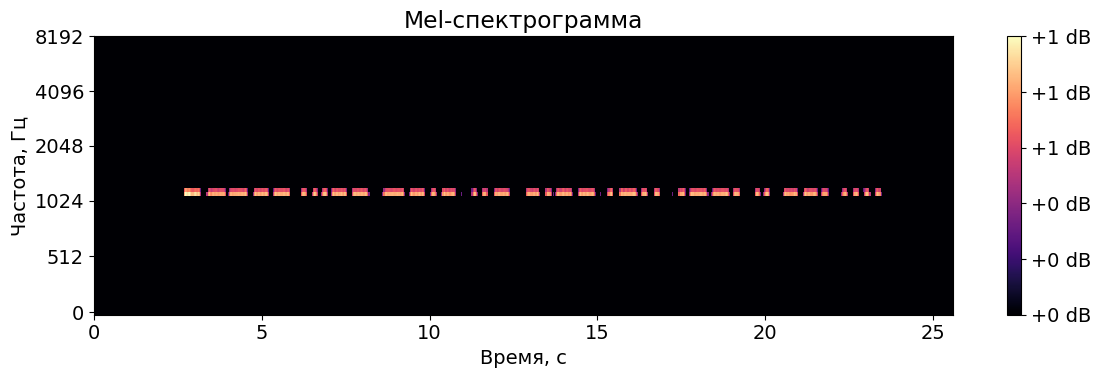

In [173]:
class Preprocessing(object):
    def __init__(self):
        self.data = train_dataframe
        self.sample_rate = 16000

    def dominantFreq(self, waveform, fmin=0, fmax=4000):
        S = librosa.feature.melspectrogram(y=waveform, sr=self.sample_rate, n_mels=192, n_fft=768, hop_length=96)
        S_dB = librosa.power_to_db(S, ref=np.max)
        mel_sums = np.sum(S_dB, axis=1)
        max_idx = np.argmax(mel_sums)
        mel_frequencies = librosa.mel_frequencies(n_mels=S_dB.shape[0], fmin=fmin, fmax=fmax)
        dominant_freq = mel_frequencies[max_idx]    

        return dominant_freq
        
    def _create_bandpass_filter(self, lowcut, highcut):
        nyquist = 0.9 * self.sample_rate
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = scp.signal.butter(4, [low, high], btype='band')
        self.filter_coeffs = (b, a)  # Сохраняем коэффициенты фильтра как атрибут класса

    def _apply_bandpass_filter(self, x):
        """Применяет сохраненный bandpass фильтр к сигналу"""
        if hasattr(self, 'filter_coeffs'):
            b, a = self.filter_coeffs
            return scp.signal.filtfilt(b, a, x)
        return x
    
    def _hard_filtering(self, waveform, cutoff_size=220):
        signal = waveform / np.max(np.abs(waveform))
        N = len(signal)

        yf = fourier.fft(signal)
        magnitude = np.abs(yf[:N//2]) / N

        max_amp = np.argmax(magnitude)
        magnitude_filt = [magnitude[i] if (max_amp - cutoff_size) < i < (max_amp + cutoff_size) 
                        else 0 for i in range(len(magnitude))]

        yf_filt = np.zeros_like(yf, dtype=complex)

        # Левая половина (положительные частоты)
        for i in range(len(magnitude_filt)):
            yf_filt[i] = yf[i] if magnitude_filt[i] != 0 else 0

        # Правая половина (отрицательные частоты — зеркальное отражение)
        # Восстановим симметрию вручную
        for i in range(1, len(magnitude_filt)):  # начинаем с 1, чтобы не задвоить DC
            yf_filt[-i] = np.conj(yf_filt[i])

        # 2. Обратное преобразование Фурье
        filtered_signal = np.real(fourier.ifft(yf_filt))

        th=0.5
        # Алгоритм для обрезки начала и конца
        l, r = 0, len(filtered_signal) - 1
        while l < len(filtered_signal):
            if filtered_signal[l] < th:
                filtered_signal[l] = 0
                # start = l
            else:
                break
            l += 1

        while r > 0:
            if filtered_signal[r] < th:
                filtered_signal[r] = 0
                # end = r
            else:
                break
            r -= 1

        return filtered_signal

    def _normalize_waveform(self, waveform):
        # RMS-нормализация
        frame_length = min(8192, len(waveform))
        hop_length = frame_length // 4
        rms = librosa.feature.rms(y=waveform, hop_length=hop_length, frame_length=frame_length)[0]
        gain_rms = 0.3 / (rms + 1e-12)
        gain_rms = np.clip(gain_rms, 2.0, 3.5)  # Ограничение

        # Применим gain покадрово
        y_rms = np.zeros_like(waveform)
        for i in range(len(rms)):
            start = i * 2048
            end = start + 8192
            y_rms[start:end] += waveform[start:end] * gain_rms[i]

        return y_rms / (np.max(np.abs(y_rms)) + 1e-8)

    def _load_and_preprocess(self, waveform):
        """Полный пайплайн предобработки"""
        # self._create_bandpass_filter(lowcut=400, highcut=2500)
        waveform = self._apply_bandpass_filter(waveform)
        waveform = self._hard_filtering(waveform)
        waveform = self._normalize_waveform(waveform)
        return waveform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx] if hasattr(self.data, 'iloc') else self.data[idx]
        
        # Загрузка аудио и преобразование в спектрограмму
        waveform = loadAudio(f"{FILES_DIR}/{row['id']}")
        waveform_pp = self._load_and_preprocess(waveform)

        return waveform_pp
    
audio = Preprocessing()

plt.figure(figsize=(12, 4))
print(audio.dominantFreq(audio.__getitem__(0)))
S_dB = computeMelSpectrogram(audio.__getitem__(0))
librosa.display.specshow(S_dB, sr=16000, x_axis="time", y_axis="mel")

plt.colorbar(format="%+2.0f dB")
plt.title("Mel-спектрограмма")
plt.xlabel("Время, с")
plt.ylabel("Частота, Гц")
plt.tight_layout()
plt.show()

In [154]:
DOT_OR_DASH = 11
SHORT_OR_LONG_BLANK = 10
BLANK_SEP_OR_SYMBOL = 30

In [161]:
# Построение сегментов
def makeSegments(S_dB):
    S_img = (S_dB * 255).astype(np.uint8)
    _, binary = cv2.threshold(S_img, 75, 255, cv2.THRESH_BINARY)
    time_activity = np.sum(binary, axis=0)
    norm_activity = time_activity / np.max(time_activity)
    smoothed = cv2.GaussianBlur(norm_activity, (15, 1), 0)

    # Выделим "активные" области
    threshold = 0.3
    active = smoothed > threshold

    seg = []
    start = None
    for i, val in enumerate(active):
        if val and start is None:
            start = i
        elif not val and start is not None:
            if i - start > 3:  # Минимальная длина символа в фреймах
                seg.append((start, i))
            start = None
    
    return seg

In [165]:
decodingToMorse(makeSegments(S_dB))

'----- ...-- --.- ..- -.-- .-.. .--. .. --. ....'

In [166]:
morseToSymb(decodingToMorse(makeSegments(S_dB)))

'03ЩУЫЛПИГХ'

In [27]:
# Аналитический декодер
def decodingToMorse(seg):
    output = ""

    p = 0
    while p < len(seg) - 1:
        if seg[p][1] - seg[p][0] <= DOT_OR_DASH:
            output += "."
        else:
            output += "-"
        
        if SHORT_OR_LONG_BLANK <= seg[p + 1][0] - seg[p][1] <= BLANK_SEP_OR_SYMBOL:
            output += " "
        
        if seg[p + 1][0] - seg[p][1] > BLANK_SEP_OR_SYMBOL:
            output += " ! "
        
        p += 1

    if seg[p][1] - seg[p][0] <= DOT_OR_DASH:
        output += "."
    else:
        output += "-"
    
    return output

def morseToSymb(seq, dict=MORSE_DICT):
    return ''.join([dict.get(code, '') for code in seq.split(' ')])

In [28]:
# Сохранение предикта
def save_predictions(predictions, out_path="prediction.csv"):
    for i in range(len(predictions)):
        predictions[i] = {'id': test_dataframe['id'][i], 'message': predictions[i]}

    pd.DataFrame(predictions).to_csv(out_path, index=False)
    print(f'Predictions saved succesfully.')

In [29]:
# Функция для подсчета метрики Levenshtein Mean
def levenshteinMean(predictions, targets):
    assert len(predictions) == len(targets), "Списки должны быть одинаковой длины"

    distances = [Levenshtein.distance(pred, tgt) for pred, tgt in zip(predictions, targets)]
    return sum(distances) / len(distances)

In [32]:
num = 10

In [ ]:
targets = list(train_dataframe['message'][0:num])
targets

['03ЩУЫЛПИГХ',
 'ЪЛТ0ДС6А3Г',
 '5ЭКЫБЗХЯН',
 'ЖЫЦОИ68КФ',
 '32Ю7МЫ ЗЛ',
 '7У98ШБ2',
 'УЗОЗ#Г8',
 'Ц Ж4 РЯХТЛ ВЕ',
 'ХЮЦ4ЙК5ГЦЯ С',
 'ЯЗЛ ЮОШЪЕ']

In [167]:
# predictions = []
# for i in range(len(test_dataframe)):
#     waveform = loadAudio(f"{FILES_DIR}/{test_dataframe['id'][i]}")
#     filtered_signal = hardFiltering(waveform)
#     y_out = normalizeRMS(filtered_signal, frame_length=4096, hop_length=1024, target_rms=0.95)
#     S_dB = computeMelSpectrogram(waveform=y_out)
#     segs = makeSegments(S_dB=S_dB)
#     output = decodingToMorse(seg=segs)
#     morse_sequence = morseToSymb(output)
#     predictions.append(morse_sequence)

predictions = []
for i in range(num):
    S_dB = computeMelSpectrogram(audio.__getitem__(i))
    segs = makeSegments(S_dB=S_dB)
    output = decodingToMorse(seg=segs)
    morse_sequence = morseToSymb(output)
    predictions.append(morse_sequence)

In [168]:
predictions

['03ЩУЫЛПИГХ',
 'ЕТЖДН6АСЕИГ',
 '5ЭКЫДЗХН',
 'ЕЕИЖОЦОИ',
 'ДТМЕ#',
 '8ШБ2',
 'УЗОЗ#Г8',
 'Ц Ж4 РЯХТЛ ВЕ',
 'ХЮЦ4ЙК5ГЦЯ С',
 'Е П ЕЕИ']

In [124]:
save_predictions(predictions)

Predictions saved succesfully.


In [102]:
predictions[0]

'03ЩУЫЛПИГХ'

In [169]:
levenshteinMean(predictions, targets)

3.6

## Предобработка для QN

In [8]:
FILES_DIR = "/Users/djinja/Desktop/Projects/Kontur Internship/morse_dataset/morse_dataset"

In [138]:
def loadAudio(path):
    waveform, _ = librosa.load(path, sr=16000)
    return waveform

def computeMelSpectrogram(waveform, sr=16000, n_fft=512, hop_length=160, n_mels=64, 
                          top_db=18, amin=1e-8, min_amp=-12):

    S = librosa.feature.melspectrogram(
        y=waveform,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    S_dB = librosa.power_to_db(S, ref=np.max, top_db=top_db, amin=amin)
    S_dB[S_dB < min_amp] = min_amp - 5
    S_dB = (S_dB - S_dB.min()) / (S_dB.max() - S_dB.min())
    return S_dB ** 3

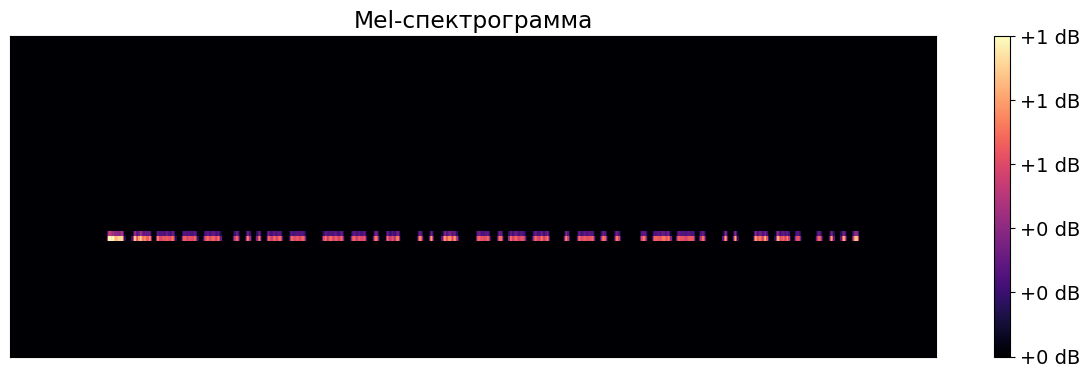

In [140]:
class Preprocessing(object):
    def __init__(self):
        self.data = train_dataframe
        self.sample_rate = 16000
        
    def _create_bandpass_filter(self, lowcut, highcut):
        nyquist = 0.9 * self.sample_rate
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = scp.signal.butter(4, [low, high], btype='band')
        self.filter_coeffs = (b, a)  # Сохраняем коэффициенты фильтра как атрибут класса

    def _apply_bandpass_filter(self, x):
        """Применяет сохраненный bandpass фильтр к сигналу"""
        if hasattr(self, 'filter_coeffs'):
            b, a = self.filter_coeffs
            return scp.signal.filtfilt(b, a, x)
        return x
    
    def _hard_filtering(self, waveform, cutoff_size=180):
        signal = waveform / np.max(np.abs(waveform))
        N = len(signal)

        yf = fourier.fft(signal)
        magnitude = np.abs(yf[:N//2]) / N

        max_amp = np.argmax(magnitude)
        magnitude_filt = [magnitude[i] if (max_amp - cutoff_size) < i < (max_amp + cutoff_size) 
                        else 0 for i in range(len(magnitude))]

        yf_filt = np.zeros_like(yf, dtype=complex)

        # Левая половина (положительные частоты)
        for i in range(len(magnitude_filt)):
            yf_filt[i] = yf[i] if magnitude_filt[i] != 0 else 0

        # Правая половина (отрицательные частоты — зеркальное отражение)
        # Восстановим симметрию вручную
        for i in range(1, len(magnitude_filt)):  # начинаем с 1, чтобы не задвоить DC
            yf_filt[-i] = np.conj(yf_filt[i])

        # 2. Обратное преобразование Фурье
        filtered_signal = np.real(fourier.ifft(yf_filt))

        th = 0.5
        # Алгоритм для обрезки начала и конца
        l, r = 0, len(filtered_signal) - 1
        while l < len(filtered_signal):
            if filtered_signal[l] < th:
                filtered_signal[l] = 0
                # start = l
            else:
                break
            l += 1

        while r > 0:
            if filtered_signal[r] < th:
                filtered_signal[r] = 0
                # end = r
            else:
                break
            r -= 1

        return filtered_signal

    def _normalize_waveform(self, waveform):
        # RMS-нормализация
        frame_length = min(8192, len(waveform))
        hop_length = frame_length // 4
        rms = librosa.feature.rms(y=waveform, hop_length=hop_length, frame_length=frame_length)[0]
        gain_rms = 0.95 / (rms + 1e-12)
        gain_rms = np.clip(gain_rms, 2.2, 3.0)  # Ограничение

        # Применим gain покадрово
        y_rms = np.zeros_like(waveform)
        for i in range(len(rms)):
            start = i * 2048
            end = start + 8192
            y_rms[start:end] += waveform[start:end] * gain_rms[i]

        return y_rms / (np.max(np.abs(y_rms)) + 1e-8)

    def _load_and_preprocess(self, waveform):
        """Полный пайплайн предобработки"""
        # self._create_bandpass_filter(lowcut=400, highcut=2500)
        waveform = self._apply_bandpass_filter(waveform)
        waveform = self._hard_filtering(waveform)
        waveform = self._normalize_waveform(waveform)
        return waveform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx] if hasattr(self.data, 'iloc') else self.data[idx]
        
        # Загрузка аудио и преобразование в спектрограмму
        waveform = loadAudio(f"{FILES_DIR}/{row['id']}")
        waveform_pp = self._load_and_preprocess(waveform)

        return waveform_pp
    
audio = Preprocessing()

plt.figure(figsize=(12, 4))
S_dB = computeMelSpectrogram(audio.__getitem__(0))
librosa.display.specshow(S_dB, sr=16000)
plt.colorbar(format="%+2.0f dB")
plt.title("Mel-спектрограмма")
plt.tight_layout()
plt.show()

In [89]:
def dom_freq(S_dB):
    max_sum = -1
    for i in range(S_dB.shape[0]):
        if sum(S_dB[i]) > max_sum:
            max_sum = sum(S_dB[i])
            dom_f = i

    start_f, end_f = dom_f - 5, dom_f + 5

    return start_f, end_f

In [91]:
plt.figure(figsize=(12, 4))
start_f, end_f = dom_freq(S_dB)
S_dB = computeMelSpectrogram(audio.__getitem__(2))[start_f:end_f]
librosa.display.specshow(S_dB, sr=16000)
plt.colorbar(format="%+2.0f dB")
plt.title("Mel-спектрограмма")
plt.tight_layout()
plt.show()

IndexError: cannot do a non-empty take from an empty axes.

<Figure size 1200x400 with 0 Axes>